<a href="https://colab.research.google.com/github/terryychiuu/Tiingo_DAY1/blob/master/trade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day1 - 串接API，取得價量資料

In [ ]:
import requests

headers = {
        'Content-Type': 'application/json'
        }
requestResponse = requests.get("https://api.tiingo.com/api/test?token=4d109a21f529efe178e73aae6e710b8c24330e71",
                                    headers=headers)
print(requestResponse.json())

{'message': 'You successfully sent a request'}


In [ ]:
import os
import pandas_datareader as pdr

SPY = pdr.get_data_tiingo('SPY', api_key='4d109a21f529efe178e73aae6e710b8c24330e71')

SPY.tail()

close    high  ...  divCash  splitFactor
symbol date                                       ...                      
SPY    2021-01-06 00:00:00+00:00  373.55  376.98  ...      0.0          1.0
       2021-01-07 00:00:00+00:00  379.10  379.90  ...      0.0          1.0
       2021-01-08 00:00:00+00:00  381.26  381.49  ...      0.0          1.0
       2021-01-11 00:00:00+00:00  378.69  380.58  ...      0.0          1.0
       2021-01-12 00:00:00+00:00  378.77  379.86  ...      0.0          1.0

[5 rows x 12 columns]

# Day2 - 繪製K線圖

In [ ]:
!pip install --upgrade mplfinance
!pip install pandas-datareader

     |████████████████████████████████| 61kB 4.3MB/s 


In [ ]:
import os
import pandas_datareader as pdr
df = pdr.get_data_tiingo('GOOG', api_key='4d109a21f529efe178e73aae6e710b8c24330e71')
df.tail()

close      high  ...  divCash  splitFactor
symbol date                                          ...                      
GOOG   2021-01-07 00:00:00+00:00  1787.25  1788.400  ...      0.0          1.0
       2021-01-08 00:00:00+00:00  1807.21  1809.840  ...      0.0          1.0
       2021-01-11 00:00:00+00:00  1766.72  1794.315  ...      0.0          1.0
       2021-01-12 00:00:00+00:00  1746.55  1778.040  ...      0.0          1.0
       2021-01-13 00:00:00+00:00  1754.40  1765.035  ...      0.0          1.0

[5 rows x 12 columns]

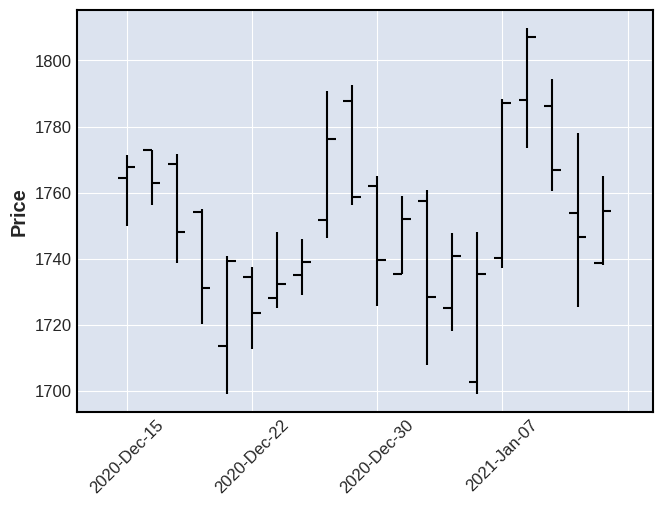

In [ ]:
# 將multi-index轉成single-index
df = df.reset_index(level=[0,1])

# 指定date為index
df.index = df['date']

# 取adjClose至adjOpen的欄位資料
df_adj = df.iloc[:,7:11]

# 更改columns的名稱，以讓mplfinance看得懂
df_adj.columns = ['Close','High','Low','Open']

# 抓取近20日的資料
df_adj_20d = df_adj.iloc[-20:,:]

# 繪製K線圖
import mplfinance as mpf
mpf.plot(df_adj_20d)

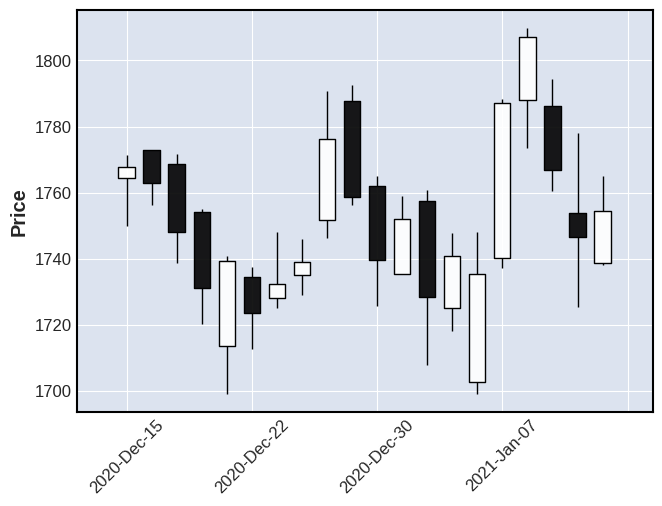

In [ ]:
mpf.plot(df_adj_20d,type='candle')

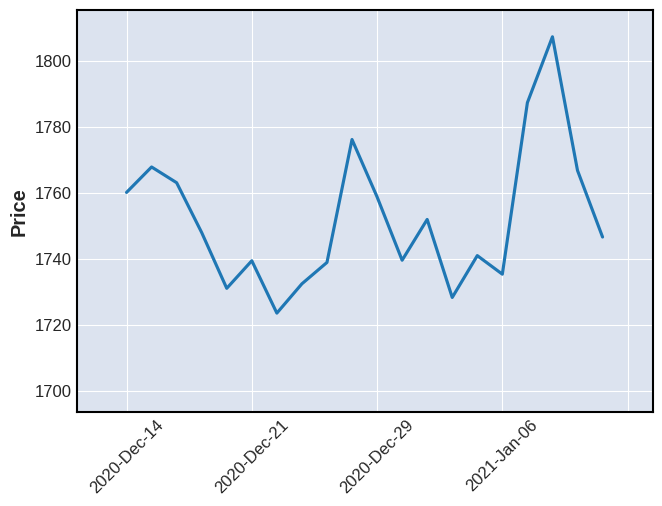

In [ ]:
mpf.plot(df_adj_20d,type='line')

# Day3 - 分析K線型態

In [ ]:
# 串接API抓取資料
import os
import pandas_datareader as pdr
SPY = pdr.get_data_tiingo('SPY', api_key='4d109a21f529efe178e73aae6e710b8c24330e71')
SPY.tail()
SPY = SPY.reset_index(level=[0,1])
SPY.index = SPY['date']
SPY_adj = SPY.iloc[:,7:11]
SPY_adj.columns = ['Close','High','Low','Open']
SPY.tail()
# 取2019年的數據
SPY_adj_2019 = SPY_adj['2019']

# 開盤價 & 收盤價
SPY_adj_2019_Open = SPY_adj_2019.Open
SPY_adj_2019_Close = SPY_adj_2019.Close

# 當日漲跌點數
SPY_DailyChg_2019 = SPY_adj_2019_Close - SPY_adj_2019_Open

SPY_Abs_DailyChg_2019 = abs(SPY_DailyChg_2019)

# 分析振幅統計數據，以利篩選適合的K棒
SPY_Abs_DailyChg_2019.describe()

count    252.000000
mean       1.148569
std        1.087967
min        0.000000
25%        0.380852
50%        0.767333
75%        1.628985
max        5.900244
dtype: float64

In [ ]:
# 抓取 第1根大振幅陽線、第2根小振幅陽線或陰線、第3根陰線且振幅大於第1根的1/2
evening_condition_1 = [0,0]
for i in range(2, len(SPY_DailyChg_2019)):
    if ( SPY_DailyChg_2019[i-2] > 1.158 ) & ( abs(SPY_DailyChg_2019[i-1]) < 0.388 ) & ( SPY_DailyChg_2019[i] < -0.58 ):
        evening_condition_1.append(1)
    else:
        evening_condition_1.append(0)

# condition 1 符合的次數
evening_condition_1.count(1)

# 第2根的開盤與收盤價 均大於 第1根的收盤與第3根的開盤
evening_condition_2 = [0,0]
for i in range(2, len(SPY_adj_2019_Open)):
    if ( SPY_adj_2019_Open[i-1] > SPY_adj_2019_Close[i-2] ) & ( SPY_adj_2019_Open[i-1] > SPY_adj_2019_Open[i] ) & ( SPY_adj_2019_Close[i-1] > SPY_adj_2019_Close[i-2] ) & ( SPY_adj_2019_Close[i-1] > SPY_adj_2019_Open[i] ):
        evening_condition_2.append(1)
    else:
        evening_condition_2.append(0)
evening_condition_2.count(1)

# Evening Star Signal
evening_star_signal = []
for i in range(len(evening_condition_1)):
    if ( evening_condition_1[i] == 1 ) & ( evening_condition_2[i] == 1 ):
        evening_star_signal.append(1)
    else:
        evening_star_signal.append(0)
        
# Find Evening Star date
for i in range(len(evening_star_signal)):
    if evening_star_signal[i] == 1:
        print(SPY_adj_2019.index[i])

2019-08-20 00:00:00+00:00


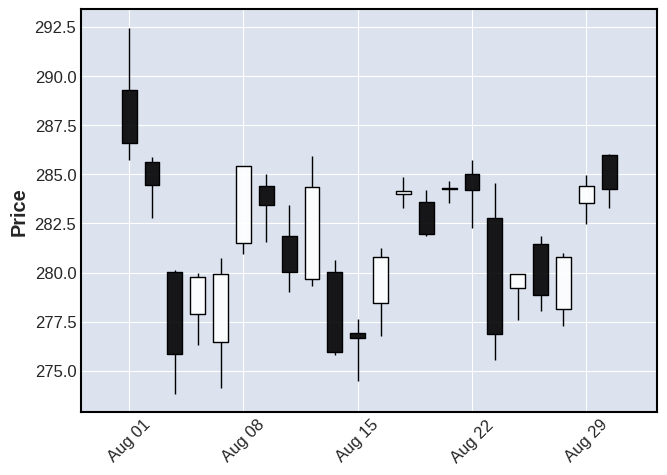

In [ ]:
import mplfinance as mpf

SPY_adj_2019_Aug = SPY_adj_2019['2019-08']
mpf.plot(SPY_adj_2019_Aug,type='candle')

# Day4 - 運用K線型態來交易

In [ ]:
import os
import pandas_datareader as pdr

##1.先抓取SPY股價資料
SPY = pdr.get_data_tiingo('SPY', api_key='4d109a21f529efe178e73aae6e710b8c24330e71')
SPY = SPY.reset_index(level=[0,1])
SPY.index = SPY['date']
SPY_adj = SPY.iloc[:,7:11]
SPY_adj.columns = ['Close','High','Low','Open']

##2.計算報酬率
SPY_Open_adj = SPY_adj.Open
SPY_Open_adj

date
2016-01-19 00:00:00+00:00    172.394476
2016-01-20 00:00:00+00:00    167.920344
2016-01-21 00:00:00+00:00    168.991237
2016-01-22 00:00:00+00:00    172.231113
2016-01-25 00:00:00+00:00    172.358167
                                ...    
2021-01-07 00:00:00+00:00    376.100000
2021-01-08 00:00:00+00:00    380.590000
2021-01-11 00:00:00+00:00    377.850000
2021-01-12 00:00:00+00:00    378.890000
2021-01-13 00:00:00+00:00    378.690000
Name: Open, Length: 1257, dtype: float64

In [ ]:
ret1 = SPY_Open_adj.shift(-2) / SPY_Open_adj.shift(-1)
ret1

date
2016-01-19 00:00:00+00:00    1.006377
2016-01-20 00:00:00+00:00    1.019172
2016-01-21 00:00:00+00:00    1.000738
2016-01-22 00:00:00+00:00    0.992102
2016-01-25 00:00:00+00:00    1.006156
                               ...   
2021-01-07 00:00:00+00:00    0.992801
2021-01-08 00:00:00+00:00    1.002752
2021-01-11 00:00:00+00:00    0.999472
2021-01-12 00:00:00+00:00         NaN
2021-01-13 00:00:00+00:00         NaN
Name: Open, Length: 1257, dtype: float64

In [ ]:
ret5 = SPY_Open_adj.shift(-6) / SPY_Open_adj.shift(-1)
ret5

date
2016-01-19 00:00:00+00:00    1.024591
2016-01-20 00:00:00+00:00    1.020139
2016-01-21 00:00:00+00:00    1.001265
2016-01-22 00:00:00+00:00    1.013743
2016-01-25 00:00:00+00:00    1.018788
                               ...   
2021-01-07 00:00:00+00:00         NaN
2021-01-08 00:00:00+00:00         NaN
2021-01-11 00:00:00+00:00         NaN
2021-01-12 00:00:00+00:00         NaN
2021-01-13 00:00:00+00:00         NaN
Name: Open, Length: 1257, dtype: float64

In [ ]:
##3.Evening Star訊號函數
def Evening_Star_Sig(data):
    # 開盤價/收盤價
    data_Open = data.Open
    data_Close = data.Close
    
    # 當日漲跌
    data_DailyChg = data_Close - data_Open
    
    # 取得每日的振幅
    data_Abs_DailyChg = abs(data_DailyChg)
    
    # 計算統計數據
    mean = data_Abs_DailyChg.mean()
    first_quar = data_Abs_DailyChg.quantile(q=0.25)
    
    # 抓取 第1根大振幅陽線、第2根小振幅陽線或陰線、第3根陰線且振幅大於第1根的1/2
    evening_condition_1 = [0,0]
    for i in range(2, len(data_DailyChg)):
        if ( data_DailyChg[i-2] > mean ) & ( abs(data_DailyChg[i-1]) < first_quar ) & ( data_DailyChg[i] < -0.5*mean ):
            evening_condition_1.append(1)
        else:
            evening_condition_1.append(0)
            
    # 第2根的開盤與收盤價 均大於 第1根的收盤與第3根的開盤
    evening_condition_2 = [0,0]
    for i in range(2, len(data_Open)):
        if ( data_Open[i-1] > data_Close[i-2] ) & ( data_Open[i-1] > data_Open[i] ) & ( data_Close[i-1] > data_Close[i-2] ) & ( data_Close[i-1] > data_Open[i] ):
            evening_condition_2.append(1)
        else:
            evening_condition_2.append(0)
            
    # Evening Star Signal
    evening_star_signal = []
    for i in range(len(evening_condition_1)):
        if ( evening_condition_1[i] == 1 ) & ( evening_condition_2[i] == 1 ):
            evening_star_signal.append(1)
        else:
            evening_star_signal.append(0)
            
    # Return a boolean series
    import pandas as pd
    sig = pd.Series(index = data.index, data = evening_star_signal)
    sig = sig.astype('bool')
    return sig



In [ ]:
sig = Evening_Star_Sig(SPY_adj)
sig

date
2016-01-19 00:00:00+00:00    False
2016-01-20 00:00:00+00:00    False
2016-01-21 00:00:00+00:00    False
2016-01-22 00:00:00+00:00    False
2016-01-25 00:00:00+00:00    False
                             ...  
2021-01-07 00:00:00+00:00    False
2021-01-08 00:00:00+00:00    False
2021-01-11 00:00:00+00:00    False
2021-01-12 00:00:00+00:00    False
2021-01-13 00:00:00+00:00    False
Length: 1257, dtype: bool

In [ ]:
##4.對照出現訊號後的報酬率
ret1[sig]

date
2016-01-19 00:00:00+00:00    1.006377
2016-01-19 00:00:00+00:00    1.006377
2016-01-19 00:00:00+00:00    1.006377
2016-01-19 00:00:00+00:00    1.006377
2016-01-19 00:00:00+00:00    1.006377
                               ...   
2016-01-19 00:00:00+00:00    1.006377
2016-01-19 00:00:00+00:00    1.006377
2016-01-19 00:00:00+00:00    1.006377
2016-01-19 00:00:00+00:00    1.006377
2016-01-19 00:00:00+00:00    1.006377
Name: Open, Length: 252, dtype: float64

In [ ]:
#5.畫平均報酬率圖
ret1[sig].mean()

1.0069589543723922

In [ ]:
ret5[sig].mean()

1.0243882564210116

<IPython.core.display.Javascript object>

Text(0, 0.5, '平均報酬率(%)')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24179 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22343 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 37228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29575 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36023 missing from current font.
  font.set_

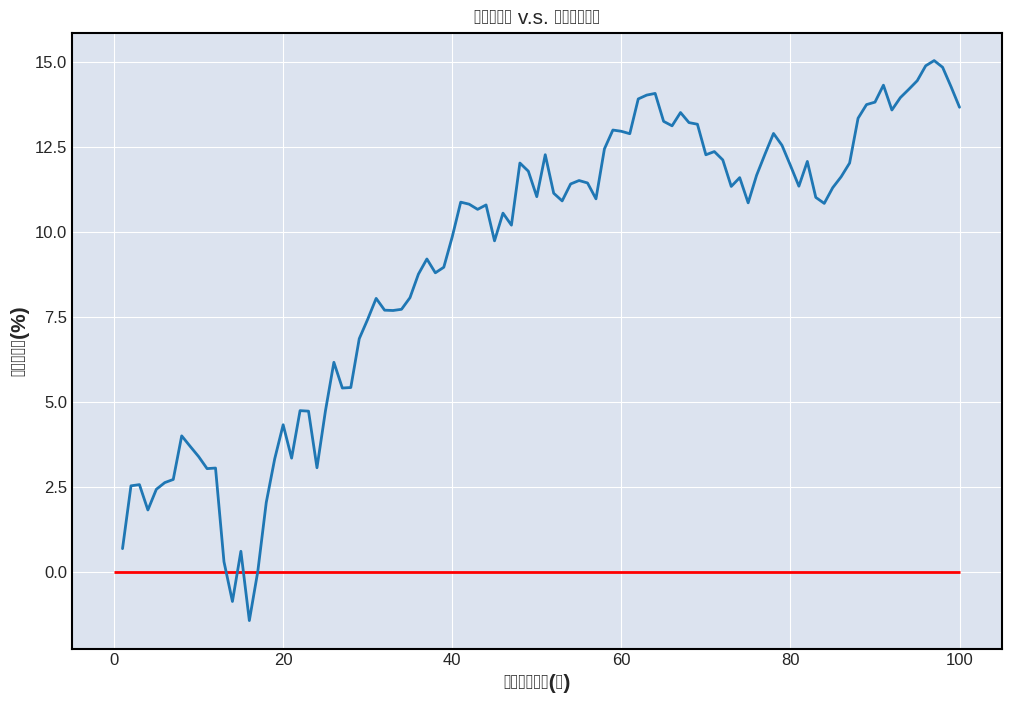

In [ ]:
# 回測 Evening star出現後，買賣間隔1~100天的平均報酬率
rets = []
for i in range(2,102):
    ret = SPY_Open_adj.shift(-i) / SPY_Open_adj.shift(-1)
    rets.append(ret[sig].mean())
    
# 畫出天數對應報酬率的圖
import pandas as pd
import matplotlib.pyplot as plt

ret_df = pd.DataFrame(index=range(1,101),data=rets)
ret_df.columns = ['return']
ret_df = (ret_df-1) * 100
plt.figure(figsize=(12,8))
plt.plot(ret_df)
plt.hlines(y=0, xmin=0, xmax=100, color='red')
plt.title("平均報酬率 v.s. 買賣間隔時間",fontsize=15)
plt.xlabel("買賣間隔天數(天)", fontsize=15)
plt.ylabel("平均報酬率(%)", fontsize=15)

# Day5 - Python計算RSI

In [ ]:
# 串接tiingo api獲取資料
import os
import pandas_datareader as pdr
SPY = pdr.get_data_tiingo('SPY', api_key='4d109a21f529efe178e73aae6e710b8c24330e71')
SPY = SPY.reset_index(level=[0,1])
SPY.index = SPY['date']
SPY_adj = SPY.iloc[:,7:12]
SPY_adj.columns = ['Close','High','Low','Open','Volume']

# 整理資料
import pandas as pd
# 收盤價
Close = SPY_adj.Close
# 日漲跌
Chg = Close - Close.shift(1)
# 上漲幅度
Chg_pos = pd.Series(index=Chg.index, data=Chg[Chg>0])
Chg_pos = Chg_pos.fillna(0)
# 下跌幅度(取正值，所以要加負號)
Chg_neg = pd.Series(index=Chg.index, data=-Chg[Chg<0])
Chg_neg = Chg_neg.fillna(0)

# 計算12日平均漲跌幅度
import numpy as np
up_mean_12 = []
down_mean_12 = []
for i in range(13,len(Chg_pos)+1):
    up_mean_12.append(np.mean(Chg_pos.values[i-12:i]))
    down_mean_12.append(np.mean(Chg_neg.values[i-12:i]))

# 計算 RSI12
rsi_12 = []
for i in range(len(up_mean_12)):
    rsi_12.append( 100 * up_mean_12[i] / ( up_mean_12[i] + down_mean_12[i] ) )
rsi_12_series = pd.Series(index = Close.index[12:], data = rsi_12)

rsi_12_series


date
2016-02-04 00:00:00+00:00    56.974010
2016-02-05 00:00:00+00:00    54.320064
2016-02-08 00:00:00+00:00    47.741010
2016-02-09 00:00:00+00:00    39.522412
2016-02-10 00:00:00+00:00    44.506264
                               ...    
2021-01-07 00:00:00+00:00    69.527559
2021-01-08 00:00:00+00:00    75.533537
2021-01-11 00:00:00+00:00    70.308620
2021-01-12 00:00:00+00:00    70.042949
2021-01-13 00:00:00+00:00    69.596803
Length: 1245, dtype: float64

In [ ]:
# RSI函數
def RSI(Close, period=12):
    # 整理資料
    import pandas as pd
    Chg = Close - Close.shift(1)
    Chg_pos = pd.Series(index=Chg.index, data=Chg[Chg>0])
    Chg_pos = Chg_pos.fillna(0)
    Chg_neg = pd.Series(index=Chg.index, data=-Chg[Chg<0])
    Chg_neg = Chg_neg.fillna(0)
    
    # 計算12日平均漲跌幅度
    import numpy as np
    up_mean = []
    down_mean = []
    for i in range(period+1, len(Chg_pos)+1):
        up_mean.append(np.mean(Chg_pos.values[i-period:i]))
        down_mean.append(np.mean(Chg_neg.values[i-period:i]))
    
    # 計算 RSI
    rsi = []
    for i in range(len(up_mean)):
        rsi.append( 100 * up_mean[i] / ( up_mean[i] + down_mean[i] ) )
    rsi_series = pd.Series(index = Close.index[period:], data = rsi)
    return rsi_series
  
# 稍微對照一下剛剛算出來的數字，會是一樣的
RSI(Close)

date
2016-02-04 00:00:00+00:00    56.974010
2016-02-05 00:00:00+00:00    54.320064
2016-02-08 00:00:00+00:00    47.741010
2016-02-09 00:00:00+00:00    39.522412
2016-02-10 00:00:00+00:00    44.506264
                               ...    
2021-01-07 00:00:00+00:00    69.527559
2021-01-08 00:00:00+00:00    75.533537
2021-01-11 00:00:00+00:00    70.308620
2021-01-12 00:00:00+00:00    70.042949
2021-01-13 00:00:00+00:00    69.596803
Length: 1245, dtype: float64

#Day6 - 用RSI指標來做交易

In [ ]:
##整理資料
# 串接API取資料
import os
import pandas_datareader as pdr
SPY = pdr.get_data_tiingo('SPY', api_key='4d109a21f529efe178e73aae6e710b8c24330e71')
SPY = SPY.reset_index(level=[0,1])
SPY.index = SPY['date']
SPY_adj = SPY.iloc[:,7:12]
SPY_adj.columns = ['Close','High','Low','Open','Volume']

# 篩選2019年收盤價資料
Close = SPY_adj.Close
Close2019 = Close['2019']

Close2019

date
2019-01-02 00:00:00+00:00    240.948766
2019-01-03 00:00:00+00:00    235.199049
2019-01-04 00:00:00+00:00    243.077220
2019-01-07 00:00:00+00:00    244.993793
2019-01-08 00:00:00+00:00    247.295605
                                ...    
2019-12-24 00:00:00+00:00    315.230313
2019-12-26 00:00:00+00:00    316.908375
2019-12-27 00:00:00+00:00    316.829869
2019-12-30 00:00:00+00:00    315.083115
2019-12-31 00:00:00+00:00    315.848547
Name: Close, Length: 252, dtype: float64

In [ ]:
# RSI函數
def RSI(Close, period=12):
    # 整理資料
    import pandas as pd
    Chg = Close - Close.shift(1)
    Chg_pos = pd.Series(index=Chg.index, data=Chg[Chg>0])
    Chg_pos = Chg_pos.fillna(0)
    Chg_neg = pd.Series(index=Chg.index, data=-Chg[Chg<0])
    Chg_neg = Chg_neg.fillna(0)
    
    # 計算平均漲跌幅度
    import numpy as np
    up_mean = []
    down_mean = []
    for i in range(period+1, len(Chg_pos)+1):
        up_mean.append(np.mean(Chg_pos.values[i-period:i]))
        down_mean.append(np.mean(Chg_neg.values[i-period:i]))
    
    # 計算 RSI
    rsi = []
    for i in range(len(up_mean)):
        rsi.append( 100 * up_mean[i] / ( up_mean[i] + down_mean[i] ) )
    rsi_series = pd.Series(index = Close.index[period:], data = rsi)
    return rsi_series

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24180 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 24180 missing from current font.
  font.set_text(s, 0, flags=flags)


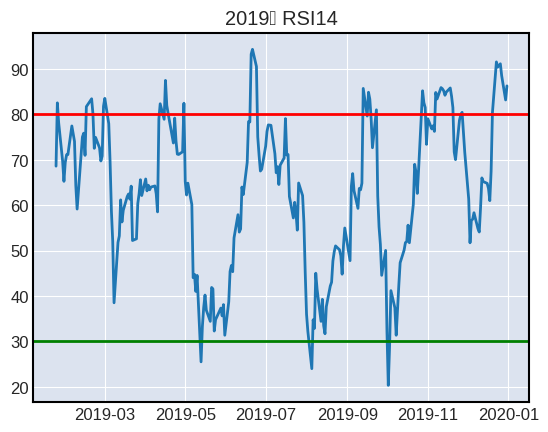

In [ ]:
# 觀察2019年的RSI14
import matplotlib.pyplot as plt
RSI14_2019 = RSI(Close2019, 14)
plt.plot(RSI14_2019)
plt.title('2019年 RSI14')
plt.axhline(y=80, color='red')
plt.axhline(y=30, color='green')

<IPython.core.display.Javascript object>

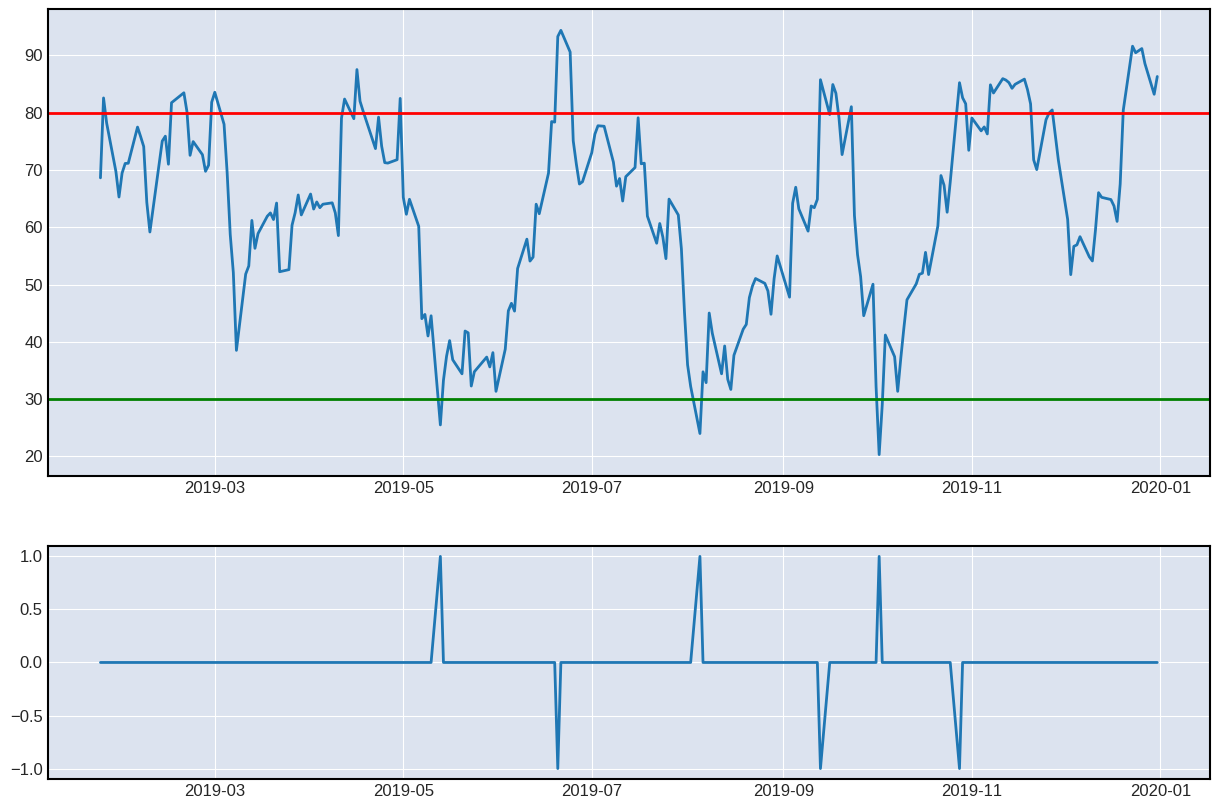

In [ ]:
# 策略： RSI14 < 30 買進，RSI14 > 80 賣出

# 訊號標籤
sig = []

# 庫存標籤，只會是0或1，表示每次交易都是買進或賣出所有部位
stock = 0

# 偵測RSI14訊號
for i in range(len(RSI14_2019)):
    if RSI14_2019[i] > 80 and stock == 1:
        stock -= 1
        sig.append(-1)
    elif RSI14_2019[i] < 30 and stock == 0:
        stock += 1
        sig.append(1)
    else:
        sig.append(0)
# 將訊號整理成dataframe
rsi_sig = pd.Series(index = RSI14_2019.index, data = sig)

import numpy as np
from matplotlib import gridspec
import pandas as pd

fig = plt.figure(figsize=(15,10))
# set height ratios for sublots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# the fisrt subplot
ax0 = plt.subplot(gs[0])
# line0 = ax0.plot(x, y, color='r')
ax0.plot(RSI14_2019)
ax0.axhline(y=80, color='red')
ax0.axhline(y=30, color='green')

#the second subplot
# shared axis X
ax1 = plt.subplot(gs[1], sharex = ax0)
rsi_sig = pd.Series(index = rsi_sig.index, data = list(rsi_sig.values))
ax1.plot(rsi_sig)

In [ ]:
# 回測2019年 RSI14訊號 績效
# 取開盤價資料做回測，因為我們是在前一天收盤後看到訊號，隔天開盤才能買進
Open = SPY_adj.Open
Open2019 = Open['2019']

# 每次買賣的報酬率
rets = []
# 是否仍有庫存
stock = 0
# 當次交易買入價格
buy_price = 0
# 當次交易賣出價格
sell_price = 0
# 每次買賣的報酬率
for i in range(len(rsi_sig)):
    if rsi_sig[i] == 1:
        # 隔日開盤買入
        buy_price = Open2019[rsi_sig.index[i+1]]
        stock += 1
    elif rsi_sig[i] == -1:
        # 隔日開盤賣出
        sell_price = Open2019[rsi_sig.index[i+1]]
        stock -= 1
        rets.append((sell_price-buy_price)/buy_price)
        # 清除上次買賣的價格
        buy_price = 0
        sell_price = 0
# 總報酬率
total_ret = 1
for ret in rets:
    total_ret *= 1 + ret
print(str(round((total_ret - 1)*100,2)) + '%')

15.72%


# Day7 - RSI交易參數最佳化

In [ ]:
##1.RSI函數，這個在之前已經寫好了
# RSI函數
def RSI(Close, period=12):
    # 整理資料
    import pandas as pd
    Chg = Close - Close.shift(1)
    Chg_pos = pd.Series(index=Chg.index, data=Chg[Chg>0])
    Chg_pos = Chg_pos.fillna(0)
    Chg_neg = pd.Series(index=Chg.index, data=-Chg[Chg<0])
    Chg_neg = Chg_neg.fillna(0)
    # 計算12日平均漲跌幅度
    import numpy as np
    up_mean = []
    down_mean = []
    for i in range(period+1, len(Chg_pos)+1):
        up_mean.append(np.mean(Chg_pos.values[i-period:i]))
        down_mean.append(np.mean(Chg_neg.values[i-period:i]))
    # 計算 RSI
    rsi = []
    for i in range(len(up_mean)):
        rsi.append( 100 * up_mean[i] / ( up_mean[i] + down_mean[i] ) )
    rsi_series = pd.Series(index = Close.index[period:], data = rsi)
    return rsi_series

##2.RSI訊號函數：參數包含RSI資料，以及指定的買賣點(例如上上一篇的80/30)。
# RSI策略函數
def RSI_Trading_Sig(RSI, upper = 80, lower = 20):
    import pandas as pd
    # 訊號標籤
    sig = []
    # 庫存標籤，只會是0或1，表示每次交易都是買進或賣出所有部位
    stock = 0
    # 偵測RSI訊號
    for i in range(len(RSI)):
        if RSI[i] > upper and stock == 1:
            stock -= 1
            sig.append(-1)
        elif RSI[i] < lower and stock == 0:
            stock += 1
            sig.append(1)
        else:
            sig.append(0)
    # 將格式轉成 time series
    rsi_sig = pd.Series(index = RSI.index, data = sig)
    return rsi_sig


##3.回測函數：參數包含買賣訊號、開盤價資料。
def RSI_backtest(RSI_Trading_Sig, Open_Price):
  # 每次買賣的報酬率
  rets = []
  # 是否仍有庫存
  stock = 0
  # 當次交易買入價格
  buy_price = 0
  # 當次交易賣出價格
  sell_price = 0
  # 每次買賣的報酬率
  for i in range(len(RSI_Trading_Sig)-1):
      if RSI_Trading_Sig[i] == 1:
          # 隔日開盤買入
          buy_price = Open_Price[RSI_Trading_Sig.index[i+1]]
          stock += 1
      elif RSI_Trading_Sig[i] == -1:
          # 隔日開盤賣出
          sell_price = Open_Price[RSI_Trading_Sig.index[i+1]]
          stock -= 1
          rets.append((sell_price-buy_price)/buy_price)
          buy_price = 0
          sell_price = 0
  # 如果最後手上有庫存，就用回測區間最後一天的開盤價賣掉
  if stock == 1 and buy_price != 0 and sell_price == 0:
      sell_price = Open_Price[-1]
      rets.append((sell_price-buy_price)/buy_price)
  # 總報酬率
  total_ret = 1
  for ret in rets:
      total_ret *= 1 + ret
  return total_ret

<IPython.core.display.Javascript object>

總報酬率：24.62%
參數：RSI計算天數: 24 ,Upper bond: 90 ,Lower bond: 24


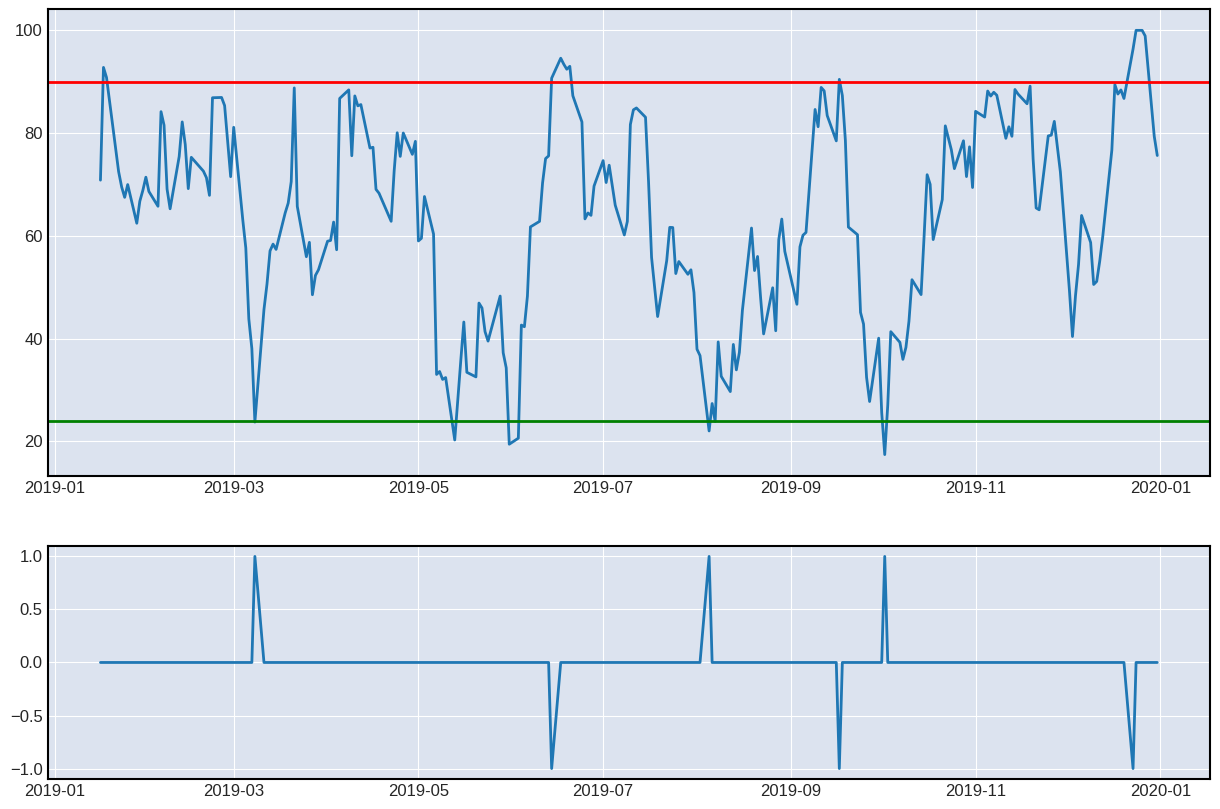

In [ ]:
# 串接API取資料
import os
import pandas_datareader as pdr
SPY = pdr.get_data_tiingo('SPY', api_key='4d109a21f529efe178e73aae6e710b8c24330e71')
SPY = SPY.reset_index(level=[0,1])
SPY.index = SPY['date']
SPY_adj = SPY.iloc[:,7:12]
SPY_adj.columns = ['Close','High','Low','Open','Volume']

# 篩選2019年開收盤價資料
Close2019 = SPY_adj.Close['2019']
Open2019 = SPY_adj.Open['2019']

# 參數最佳化 No1，所有參數皆可調整
max_total_ret, max_period, max_upper, max_lower = 0, 0, 0, 0
for period in range(6,25):
    for upper in range(70,91):
        for lower in range(10,31):
            ret = RSI_backtest(RSI_Trading_Sig(RSI(Close2019, period), upper, lower), Open2019)
            if ret > max_total_ret:
                max_total_ret, max_period, max_upper, max_lower = ret, period, upper, lower

# 將求出來的結果印出參數及圖看看
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import gridspec

x = RSI(Close2019, max_period).index
y = RSI(Close2019, max_period).values

fig = plt.figure(figsize=(15,10))
# set height ratios for sublots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# the fisrt subplot
ax0 = plt.subplot(gs[0])
# line0 = ax0.plot(x, y, color='r')
ax0.plot(RSI(Close2019, max_period))
ax0.axhline(y=max_upper, color='red')
ax0.axhline(y=max_lower, color='green')

#the second subplot
# shared axis X
ax1 = plt.subplot(gs[1], sharex = ax0)
rsi_sig = pd.Series(index = RSI(Close2019, max_period).index, data = list(RSI_Trading_Sig(RSI(Close2019, max_period), max_upper, max_lower).values))
ax1.plot(rsi_sig)

print('總報酬率：' + str(round(100*(max_total_ret-1),2)) + '%')
print('參數：' + 'RSI計算天數: ' + str(period) + ' ,Upper bond: ' + str(max_upper) + ' ,Lower bond: ' + str(max_lower))
plt.show()

# Day8 - 好用的技術指標函數庫TA-Lib

In [ ]:
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib

Selecting previously unselected package libta-lib0.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.6/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

  Using cached https://files.pythonhosted.org/packages/ac/cf/681911aa31e04ba171ab4d523a412f4a746e30d3eacb1738799d181e028b/TA-Lib-0.4.19.tar.gz
  Created wheel for ta-lib: filename=TA_Lib-0.4.19-cp36-cp36m-linux_x86_64.whl size=1437779 sha256=63154df62fe684f722d05c40eee9fe3d2b960699081dfd7ea040367cfb13af08
  Stored in directory: /root/.cache/pip/wheels/a3/f6/12/3

In [ ]:
import numpy
import talib
# 看一下全部的函數，https://mrjbq7.github.io/ta-lib/funcs.html
all_functions = talib.get_functions()
print(len(all_functions))
print(all_functions)

158
['HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE', 'ADD', 'DIV', 'MAX', 'MAXINDEX', 'MIN', 'MININDEX', 'MINMAX', 'MINMAXINDEX', 'MULT', 'SUB', 'SUM', 'ACOS', 'ASIN', 'ATAN', 'CEIL', 'COS', 'COSH', 'EXP', 'FLOOR', 'LN', 'LOG10', 'SIN', 'SINH', 'SQRT', 'TAN', 'TANH', 'ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL', 'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJIST

In [ ]:
all_groups = talib.get_function_groups()
print(len(all_groups))
print(all_groups)

10
{'Cycle Indicators': ['HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE'], 'Math Operators': ['ADD', 'DIV', 'MAX', 'MAXINDEX', 'MIN', 'MININDEX', 'MINMAX', 'MINMAXINDEX', 'MULT', 'SUB', 'SUM'], 'Math Transform': ['ACOS', 'ASIN', 'ATAN', 'CEIL', 'COS', 'COSH', 'EXP', 'FLOOR', 'LN', 'LOG10', 'SIN', 'SINH', 'SQRT', 'TAN', 'TANH'], 'Momentum Indicators': ['ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR'], 'Overlap Studies': ['BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA'], 'Pattern Recognition': ['CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBEL

In [ ]:
import os
import pandas_datareader as pdr

##1.一樣先取得OHLC資料
SPY = pdr.get_data_tiingo('SPY', api_key='4d109a21f529efe178e73aae6e710b8c24330e71')
SPY = SPY.reset_index(level=[0,1])
SPY.index = SPY['date']
SPY_adj = SPY.iloc[:,7:12]
SPY_adj.columns = ['Close','High','Low','Open','Volume']

##2.套用函數計算5MA
# 5日均線
MA5 = talib.SMA(SPY_adj.Close, timeperiod=5)
MA5

date
2016-01-19 00:00:00+00:00           NaN
2016-01-20 00:00:00+00:00           NaN
2016-01-21 00:00:00+00:00           NaN
2016-01-22 00:00:00+00:00           NaN
2016-01-25 00:00:00+00:00    170.354341
                                ...    
2021-01-07 00:00:00+00:00    373.330000
2021-01-08 00:00:00+00:00    374.806000
2021-01-11 00:00:00+00:00    376.786000
2021-01-12 00:00:00+00:00    378.274000
2021-01-13 00:00:00+00:00    379.522000
Length: 1257, dtype: float64

In [ ]:
# K pattern recognition
EVENINGSTAR = talib.CDLEVENINGSTAR(SPY_adj.Open.values,SPY_adj.High.values,SPY_adj.Low.values,SPY_adj.Close.values)
EVENINGSTAR[EVENINGSTAR!=0]

array([-100, -100, -100, -100, -100, -100], dtype=int32)

# Day9 - 撰寫一個均線策略

(array([737060., 737119., 737180., 737241., 737303., 737364., 737425.]),
 <a list of 7 Text major ticklabel objects>)

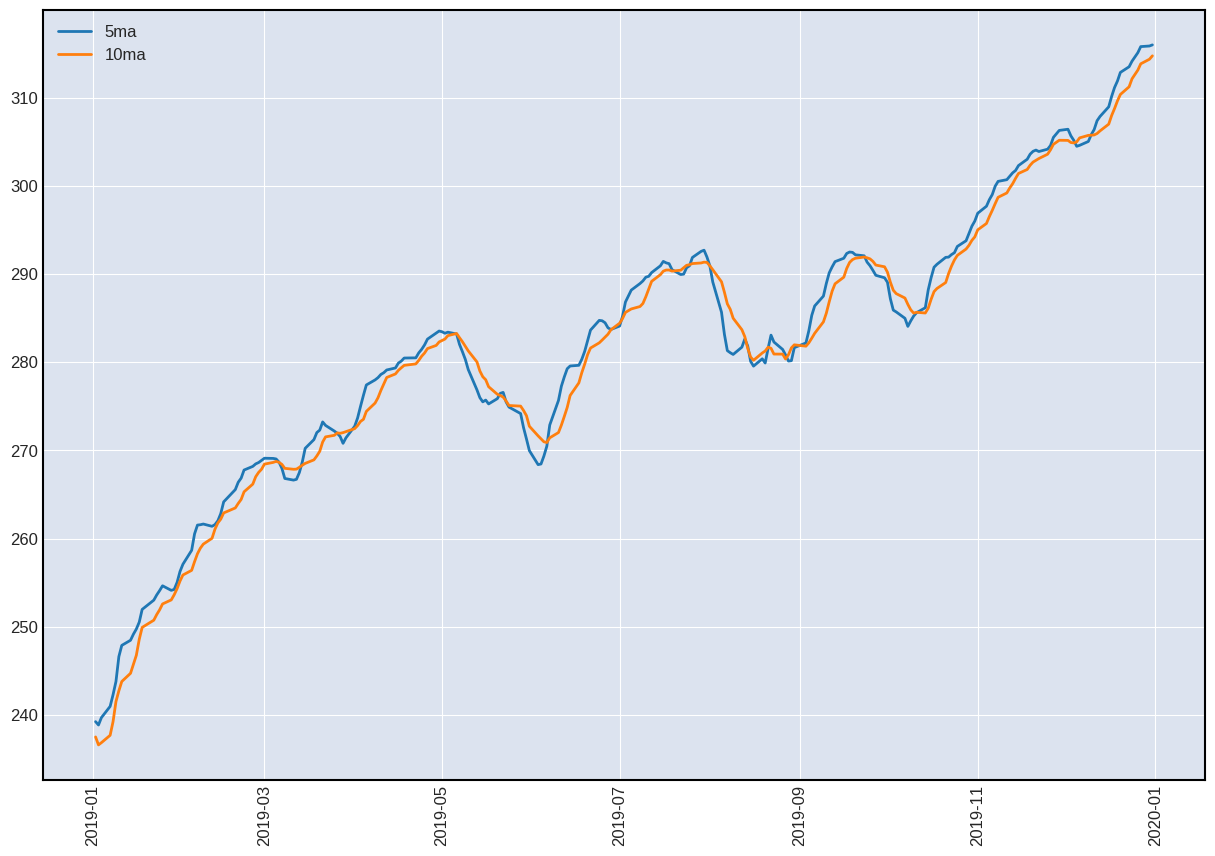

In [ ]:
# 取開盤價、收盤價
close = SPY_adj.Close
Open = SPY_adj.Open
Open2019 = Open['2019']

# 計算均線
import talib
ma5 = talib.SMA(close, timeperiod=5)
ma10 = talib.SMA(close, timeperiod=10)

# 繪圖
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.plot(ma5['2019'])
plt.plot(ma10['2019'])
plt.legend(['5ma','10ma'])
plt.xticks(rotation='vertical')

In [ ]:
# 5ma與10ma差距
MA_dif = ma5 - ma10
MA_dif = MA_dif['2019']

# 參數
stock = 0
sig = [] 

# 訊號
for i in range(len(MA_dif)):
    # 5MA往上穿越10MA
    if MA_dif[i-1] < 0 and MA_dif[i] > 0 and stock == 0:
        stock += 1
        sig.append(1)
    
    # 5MA往下穿越10MA
    elif MA_dif[i-1] > 0 and MA_dif[i] < 0 and stock == 1:
        stock -= 1
        sig.append(-1)
    else:
        sig.append(0)

# 製作dataframe
import pandas as pd
ma_sig = pd.Series(index = MA_dif.index, data = sig)
ma_sig_2019 = ma_sig['2019']


# 每次買賣的報酬率
rets = []
transaction = []

# 是否仍有庫存
stock = 0
stock_his = []

# 當次交易買入價格
buy_price = 0

# 當次交易賣出價格
sell_price = 0

# 每次買賣的報酬率
for i in range(len(ma_sig_2019)-1):
    stock_his.append(stock)
    if ma_sig_2019[i] == 1:
        # 隔日開盤買入
        buy_price = Open2019[ma_sig_2019.index[i+1]]
        stock += 1
        # 紀錄交易日期
        transaction.append([ma_sig_2019.index[i+1],'buy'])
    elif ma_sig_2019[i] == -1:
        # 隔日開盤賣出
        sell_price = Open2019[ma_sig_2019.index[i+1]]
        stock -= 1
        rets.append((sell_price-buy_price)/buy_price)
        # 賣出後就清空資料
        buy_price = 0
        sell_price = 0
        # 紀錄交易日期
        transaction.append([ma_sig_2019.index[i+1],'sell'])

# 如果最後手上有庫存，就用回測區間最後一天的開盤價賣掉
if stock == 1 and buy_price != 0 and sell_price == 0:
    sell_price = Open2019[-1]
    rets.append((sell_price-buy_price)/buy_price)
    stock -= 1
    transaction.append([Open2019.index[-1],'sell'])

# 總報酬率
total_ret = 1
for ret in rets:
    total_ret *= 1 + ret
# print(str(round((total_ret - 1)*100,2)) + '%')
print('總報酬率：' + str(round(100*(total_ret-1),2)) + '%')
transaction

總報酬率：12.72%


[[Timestamp('2019-03-15 00:00:00+0000', tz='UTC'), 'buy'],
 [Timestamp('2019-03-27 00:00:00+0000', tz='UTC'), 'sell'],
 [Timestamp('2019-04-02 00:00:00+0000', tz='UTC'), 'buy'],
 [Timestamp('2019-05-07 00:00:00+0000', tz='UTC'), 'sell'],
 [Timestamp('2019-05-22 00:00:00+0000', tz='UTC'), 'buy'],
 [Timestamp('2019-05-24 00:00:00+0000', tz='UTC'), 'sell'],
 [Timestamp('2019-06-10 00:00:00+0000', tz='UTC'), 'buy'],
 [Timestamp('2019-07-02 00:00:00+0000', tz='UTC'), 'sell'],
 [Timestamp('2019-07-03 00:00:00+0000', tz='UTC'), 'buy'],
 [Timestamp('2019-07-23 00:00:00+0000', tz='UTC'), 'sell'],
 [Timestamp('2019-07-29 00:00:00+0000', tz='UTC'), 'buy'],
 [Timestamp('2019-08-02 00:00:00+0000', tz='UTC'), 'sell'],
 [Timestamp('2019-08-15 00:00:00+0000', tz='UTC'), 'buy'],
 [Timestamp('2019-08-16 00:00:00+0000', tz='UTC'), 'sell'],
 [Timestamp('2019-08-23 00:00:00+0000', tz='UTC'), 'buy'],
 [Timestamp('2019-08-29 00:00:00+0000', tz='UTC'), 'sell'],
 [Timestamp('2019-09-04 00:00:00+0000', tz='UTC'

# Day10 - backtrader回測框架實作(一)均線交叉策略

In [ ]:
!pip install backtrader

     |████████████████████████████████| 419kB 8.4MB/s 


2019-03-14, BUY , Price: 271.08
2019-03-26, SELL , Price: 271.91
2019-04-01, BUY , Price: 275.5
2019-05-06, SELL , Price: 279.9
2019-05-21, BUY , Price: 276.59
2019-05-23, SELL , Price: 274.0
2019-06-07, BUY , Price: 276.69
2019-07-01, SELL , Price: 288.48
2019-07-02, BUY , Price: 287.44
2019-07-22, SELL , Price: 289.39
2019-07-26, BUY , Price: 292.45
2019-08-01, SELL , Price: 289.38
2019-08-14, BUY , Price: 280.11
2019-08-15, SELL , Price: 277.01
2019-08-22, BUY , Price: 285.13
2019-09-03, BUY , Price: 282.54
2019-09-24, SELL , Price: 292.48
2019-10-14, BUY , Price: 289.08
2019-12-05, SELL , Price: 305.01
2019-12-10, BUY , Price: 306.56


<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 5 Axes>]]

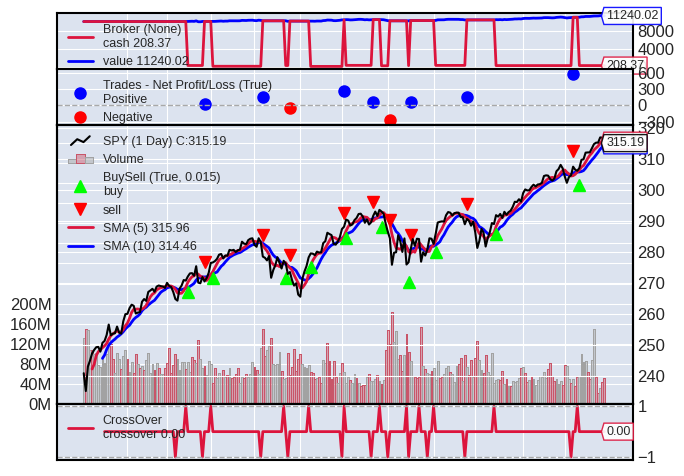

In [ ]:
##1.餵資料(Data Feeds)
# data feeds
import math
import datetime
import backtrader as bt
import backtrader.feeds as btfeeds

# 從Yahoo Finance取得資料
data = btfeeds.YahooFinanceData(dataname='SPY', 
                                fromdate=datetime.datetime(2019, 1, 1),
                                todate=datetime.datetime(2019, 12, 31))

##2.撰寫策略
# sma cross strategy
class SmaCross(bt.Strategy):
    # 交易紀錄
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    # 設定交易參數
    params = dict(
        ma_period_short=5,
        ma_period_long=10
    )

    def __init__(self):
        # 均線交叉策略
        sma1 = bt.ind.SMA(period=self.p.ma_period_short)
        sma2 = bt.ind.SMA(period=self.p.ma_period_long)
        self.crossover = bt.ind.CrossOver(sma1, sma2)
        
        # 使用自訂的sizer函數，將帳上的錢all-in
        self.setsizer(sizer())
        
        # 用開盤價做交易
        self.dataopen = self.datas[0].open

    def next(self):
        # 帳戶沒有部位
        if not self.position:
            # 5ma往上穿越20ma
            if self.crossover > 0:
                # 印出買賣日期與價位
                self.log('BUY ' + ', Price: ' + str(self.dataopen[0]))
                # 使用開盤價買入標的
                self.buy(price=self.dataopen[0])
        # 5ma往下穿越20ma
        elif self.crossover < 0:
            # 印出買賣日期與價位
            self.log('SELL ' + ', Price: ' + str(self.dataopen[0]))
            # 使用開盤價賣出標的
            self.close(price=self.dataopen[0])

# 計算交易部位
class sizer(bt.Sizer):
    def _getsizing(self, comminfo, cash, data, isbuy):
        if isbuy:
            return math.floor(cash/data[1])
        else:
            return self.broker.getposition(data)

##3.執行回測 and 顯示分析圖表
# 初始化cerebro
cerebro = bt.Cerebro()
# feed data
cerebro.adddata(data)
# add strategy
cerebro.addstrategy(SmaCross)
# run backtest
cerebro.run()
# plot diagram
cerebro.plot()


# Day11 - backtrader回測框架實作(二)唐奇安通道策略

Starting Value: 1000.00
Ending Value: 1400.39


<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 4 Axes>]]

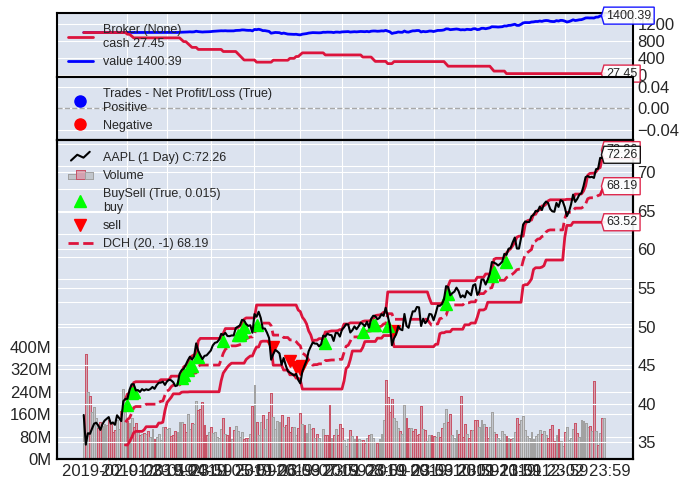

In [ ]:
from datetime import datetime
import backtrader as bt

# 定義一個Indicator物件
class DonchianChannels(bt.Indicator):
    # 這個物件的別名，所以後面我們可以用DCH/DonchianChannel來呼叫這個指標
    alias = ('DCH', 'DonchianChannel',)
    
    # 三條線分別代表唐奇安通道中的 中軌(上軌加下軌再除以2)、上軌、下軌
    lines = ('dcm', 'dch', 'dcl',)  # dc middle, dc high, dc low
    
    # 軌道的計算方式：用過去20天的資料來計算，所以period是20，lookback的意思是要不要將今天的資料納入計算，由於唐奇安通道是取過去20天的最高或最低，所以一定不能涵蓋今天，不然永遠不會有訊號出現，所以要填-1(從前一天開始算20天)
    params = dict(
        period=20,
        lookback=-1,  # consider current bar or not
    )
    
    # 是否要將Indicators另外畫一張圖，然而通道線通常都是跟股價圖畫在同一張，才能看得出相對關係，所以這裡就填subplot=False
    plotinfo = dict(subplot=False)  # plot along with data
    
    # 繪圖設定，ls是line style，'--'代表虛線
    plotlines = dict(
        dcm=dict(ls='--'),  # dashed line
        dch=dict(_samecolor=True),  # use same color as prev line (dcm)
        dcl=dict(_samecolor=True),  # use same color as prev line (dch)
    )
    
    def __init__(self):
        # hi與lo是指每日股價的最高與最低價格
        hi, lo = self.data.high, self.data.low
        
        # 視需求決定是否要從前一天開始讀資料，上面已經定義lookback存在，所以這邊會直接從前一天的資料開始跑
        if self.p.lookback:  # move backwards as needed
            hi, lo = hi(self.p.lookback), lo(self.p.lookback)
        
        # 定義三條線的計算方式
        self.l.dch = bt.ind.Highest(hi, period=self.p.period)
        self.l.dcl = bt.ind.Lowest(lo, period=self.p.period)
        self.l.dcm = (self.l.dch + self.l.dcl) / 2.0  # avg of the above

# 撰寫交易策略
class MyStrategy(bt.Strategy):
    def __init__(self):
        # DCH就是上面定義的 DonchianChannels的alias
        self.myind = DCH()

    def next(self):
        if self.data[0] > self.myind.dch[0]:
            self.buy()
        elif self.data[0] < self.myind.dcl[0]:
            self.sell()

cerebro = bt.Cerebro()
cerebro.addstrategy(MyStrategy)
cerebro.broker.setcash(1000)
cerebro.broker.setcommission(commission=0.001)

data = bt.feeds.YahooFinanceData(dataname='AAPL',
                                 fromdate=datetime(2019, 1, 1),
                                 todate=datetime(2019, 12, 31))
cerebro.adddata(data)
print('Starting Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Ending Value: %.2f' % cerebro.broker.getvalue())
cerebro.plot()

# Day12 - backtrader回測框架實作(三)Sizers模組

In [ ]:
### From Day10

##1.餵資料(Data Feeds)
# data feeds
import math
import datetime
import backtrader as bt
import backtrader.feeds as btfeeds

# 從Yahoo Finance取得資料
data = btfeeds.YahooFinanceData(dataname='SPY', 
                                fromdate=datetime.datetime(2019, 1, 1),
                                todate=datetime.datetime(2019, 12, 31))

##2.撰寫策略
# sma cross strategy
class SmaCross(bt.Strategy):
    # 交易紀錄
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    # 設定交易參數
    params = dict(
        ma_period_short=5,
        ma_period_long=10
    )

    def __init__(self):
        # 均線交叉策略
        sma1 = bt.ind.SMA(period=self.p.ma_period_short)
        sma2 = bt.ind.SMA(period=self.p.ma_period_long)
        self.crossover = bt.ind.CrossOver(sma1, sma2)
        
        # 使用自訂的sizer函數，將帳上的錢all-in
        self.setsizer(sizer())
        
        # 用開盤價做交易
        self.dataopen = self.datas[0].open

    def next(self):
        # 帳戶沒有部位
        if not self.position:
            # 5ma往上穿越20ma
            if self.crossover > 0:
                # 印出買賣日期與價位
                self.log('BUY ' + ', Price: ' + str(self.dataopen[0]))
                # 使用開盤價買入標的
                self.buy(price=self.dataopen[0])
        # 5ma往下穿越20ma
        elif self.crossover < 0:
            # 印出買賣日期與價位
            self.log('SELL ' + ', Price: ' + str(self.dataopen[0]))
            # 使用開盤價賣出標的
            self.close(price=self.dataopen[0])

# 計算交易部位
class sizer(bt.Sizer):
    def _getsizing(self, comminfo, cash, data, isbuy):
        if isbuy:
            return math.floor(cash/data[1])
        else:
            return self.broker.getposition(data)

##3.執行回測 and 顯示分析圖表
# 初始化cerebro
cerebro = bt.Cerebro()
cerebro.addsizer(bt.sizers.SizerFix, stake=20) ###################### edited
# feed data
cerebro.adddata(data)
# add strategy
cerebro.addstrategy(SmaCross)
# run backtest
cerebro.run()
# plot diagram
cerebro.plot()


2019-03-14, BUY , Price: 271.08
2019-03-26, SELL , Price: 271.91
2019-04-01, BUY , Price: 275.5
2019-05-06, SELL , Price: 279.9
2019-05-21, BUY , Price: 276.59
2019-05-23, SELL , Price: 274.0
2019-06-07, BUY , Price: 276.69
2019-07-01, SELL , Price: 288.48
2019-07-02, BUY , Price: 287.44
2019-07-22, SELL , Price: 289.39
2019-07-26, BUY , Price: 292.45
2019-08-01, SELL , Price: 289.38
2019-08-14, BUY , Price: 280.11
2019-08-15, SELL , Price: 277.01
2019-08-22, BUY , Price: 285.13
2019-08-28, SELL , Price: 278.24
2019-09-03, BUY , Price: 282.54
2019-09-24, SELL , Price: 292.48
2019-10-14, BUY , Price: 289.08
2019-12-05, SELL , Price: 305.01
2019-12-10, BUY , Price: 306.56


<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 5 Axes>]]

# Day13 - backtrader回測框架實作(四) Observers模組

2019-03-14, BUY , Price: 271.08
2019-03-26, SELL , Price: 271.91
2019-04-01, BUY , Price: 275.5
2019-05-06, SELL , Price: 279.9
2019-05-21, BUY , Price: 276.59
2019-05-23, SELL , Price: 274.0
2019-06-07, BUY , Price: 276.69
2019-07-01, SELL , Price: 288.48
2019-07-02, BUY , Price: 287.44
2019-07-22, SELL , Price: 289.39
2019-07-26, BUY , Price: 292.45
2019-08-01, SELL , Price: 289.38
2019-08-14, BUY , Price: 280.11
2019-08-15, SELL , Price: 277.01
2019-08-22, BUY , Price: 285.13
2019-09-03, BUY , Price: 282.54
2019-09-24, SELL , Price: 292.48
2019-10-14, BUY , Price: 289.08
2019-12-05, SELL , Price: 305.01
2019-12-10, BUY , Price: 306.56


<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 4 Axes>]]

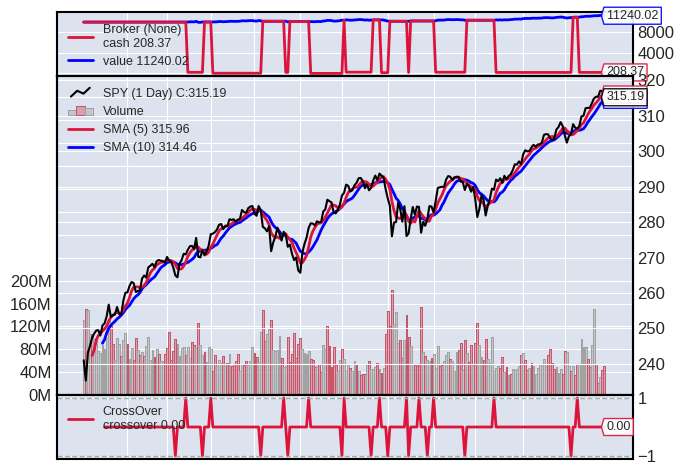

In [ ]:
# 初始化cerebro
cerebro = bt.Cerebro(stdstats=False)
# 加上下面這一行
cerebro.addobserver(bt.observers.Broker)
cerebro.adddata(data)
cerebro.addstrategy(SmaCross)
cerebro.run()
cerebro.plot()

2019-03-14, BUY , Price: 271.08
2019-03-26, SELL , Price: 271.91
2019-04-01, BUY , Price: 275.5
2019-05-06, SELL , Price: 279.9
2019-05-21, BUY , Price: 276.59
2019-05-23, SELL , Price: 274.0
2019-06-07, BUY , Price: 276.69
2019-07-01, SELL , Price: 288.48
2019-07-02, BUY , Price: 287.44
2019-07-22, SELL , Price: 289.39
2019-07-26, BUY , Price: 292.45
2019-08-01, SELL , Price: 289.38
2019-08-14, BUY , Price: 280.11
2019-08-15, SELL , Price: 277.01
2019-08-22, BUY , Price: 285.13
2019-09-03, BUY , Price: 282.54
2019-09-24, SELL , Price: 292.48
2019-10-14, BUY , Price: 289.08
2019-12-05, SELL , Price: 305.01
2019-12-10, BUY , Price: 306.56


<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 5 Axes>]]

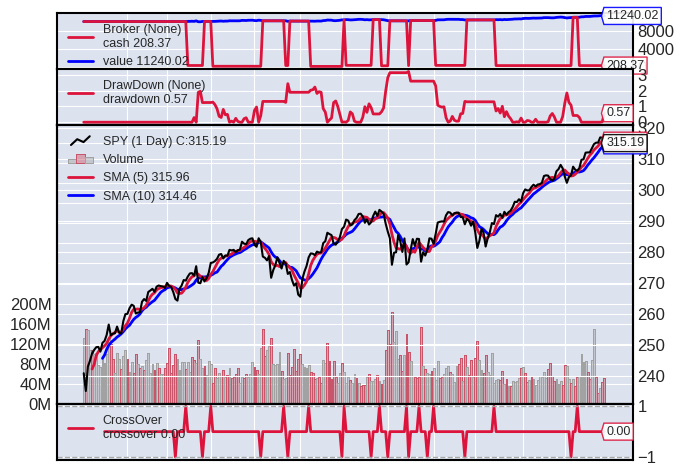

In [ ]:
cerebro = bt.Cerebro(stdstats=False)
# 加上下面這一行
cerebro.addobserver(bt.observers.Broker)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.adddata(data)
cerebro.addstrategy(SmaCross)
cerebro.run()
cerebro.plot()

2019-03-14, BUY , Price: 271.08
2019-03-14, DrawDown: 0.00
2019-03-14, MaxDrawDown: 0.00
2019-03-26, SELL , Price: 271.91
2019-04-01, BUY , Price: 275.5
2019-04-01, DrawDown: 1.24
2019-04-01, MaxDrawDown: 1.95
2019-05-06, SELL , Price: 279.9
2019-05-21, BUY , Price: 276.59
2019-05-21, DrawDown: 1.31
2019-05-21, MaxDrawDown: 1.95
2019-05-23, SELL , Price: 274.0
2019-06-07, BUY , Price: 276.69
2019-06-07, DrawDown: 1.89
2019-06-07, MaxDrawDown: 2.43
2019-07-01, SELL , Price: 288.48
2019-07-02, BUY , Price: 287.44
2019-07-02, DrawDown: 0.48
2019-07-02, MaxDrawDown: 2.43
2019-07-22, SELL , Price: 289.39
2019-07-26, BUY , Price: 292.45
2019-07-26, DrawDown: 0.52
2019-07-26, MaxDrawDown: 2.43
2019-08-01, SELL , Price: 289.38
2019-08-14, BUY , Price: 280.11
2019-08-14, DrawDown: 3.13
2019-08-14, MaxDrawDown: 3.13
2019-08-15, SELL , Price: 277.01
2019-08-22, BUY , Price: 285.13
2019-08-22, DrawDown: 2.59
2019-08-22, MaxDrawDown: 3.20
2019-09-03, BUY , Price: 282.54
2019-09-03, DrawDown: 2.59
2

<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 5 Axes>]]

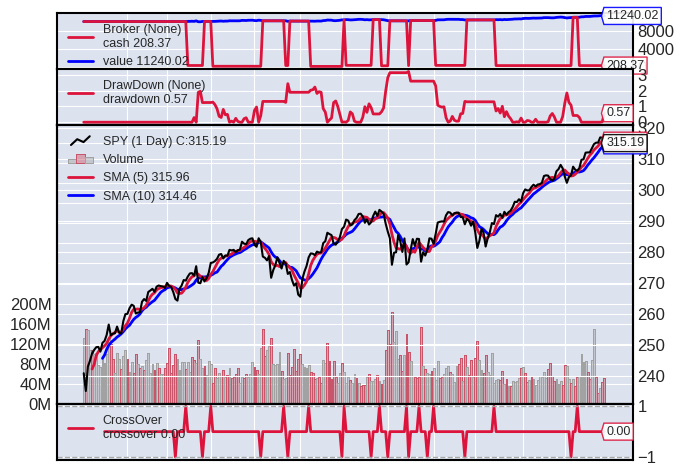

In [ ]:
###DAY10(edited)

##1.餵資料(Data Feeds)
# data feeds

import math
import datetime
import backtrader as bt
import backtrader.feeds as btfeeds

# 從Yahoo Finance取得資料
data = btfeeds.YahooFinanceData(dataname='SPY', 
                                fromdate=datetime.datetime(2019, 1, 1),
                                todate=datetime.datetime(2019, 12, 31))

##2.撰寫策略
# sma cross strategy
class SmaCross(bt.Strategy):
    # 交易紀錄
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
    
    # 設定交易參數
    params = dict(
        ma_period_short=5,
        ma_period_long=10
    )

    def __init__(self):
        # 均線交叉策略
        sma1 = bt.ind.SMA(period=self.p.ma_period_short)
        sma2 = bt.ind.SMA(period=self.p.ma_period_long)
        self.crossover = bt.ind.CrossOver(sma1, sma2)
        
        # 使用自訂的sizer函數，將帳上的錢all-in
        self.setsizer(sizer())
        
        # 用開盤價做交易
        self.dataopen = self.datas[0].open

    def next(self):
        # 帳戶沒有部位
        if not self.position:
            # 5ma往上穿越20ma
            if self.crossover > 0:
                # 印出買賣日期與價位
                self.log('BUY ' + ', Price: ' + str(self.dataopen[0]))
                self.log('DrawDown: %.2f' % self.stats.drawdown.drawdown[-1])
                self.log('MaxDrawDown: %.2f' % self.stats.drawdown.maxdrawdown[-1])
                # 使用開盤價買入標的
                self.buy(price=self.dataopen[0])
        # 5ma往下穿越20ma
        elif self.crossover < 0:
            # 印出買賣日期與價位
            self.log('SELL ' + ', Price: ' + str(self.dataopen[0]))
            # 使用開盤價賣出標的
            self.close(price=self.dataopen[0])

# 計算交易部位
class sizer(bt.Sizer):
    def _getsizing(self, comminfo, cash, data, isbuy):
        if isbuy:
            return math.floor(cash/data[1])
        else:
            return self.broker.getposition(data)

cerebro = bt.Cerebro(stdstats=False)
# 加上下面這一行
cerebro.addobserver(bt.observers.Broker)
cerebro.addobserver(bt.observers.DrawDown)
cerebro.adddata(data)
cerebro.addstrategy(SmaCross)
cerebro.run()
cerebro.plot()


# Day14 - 串接券商API做交易(一) IB + IbPy

In [ ]:
!pip install IbPy2

     |████████████████████████████████| 61kB 4.1MB/s 
  Created wheel for IbPy2: filename=IbPy2-0.8.0-cp36-none-any.whl size=60238 sha256=258df2881ab74958fb6931aa1074cc27476ebfbf5dcd2e7cf5892eeb5796adcb
  Stored in directory: /root/.cache/pip/wheels/64/81/02/96c4121b18295eff484cbf13ed155a4a2a60310453442a72fc
Successfully built IbPy2


In [ ]:
# 先import 契約/下單/連接/訊息模組
from ib.ext.Contract import Contract
from ib.ext.Order import Order
from ib.opt import Connection, message

import time


# 處理server訊息用
def error_handler(msg):
    print("Server Error: %s" % msg)

def reply_handler(msg):
    print("Server Response: %s, %s" % (msg.typeName, msg))
    
# 撰寫契約規格，就是說明你要買賣什麼商品
def create_contract(symbol, sec_type, exch, prim_exch, curr):
    contract = Contract()
    # 商品代號
    contract.m_symbol = symbol
    # 商品種類：例如STK代表STOCK
    contract.m_secType = sec_type
    contract.m_exchange = exch
    contract.m_primaryExch = prim_exch
    contract.m_currency = curr
    return contract

# 撰寫委託單，跟在APP下單一樣，要告訴券商你要下哪一種單(市價單/限價單...)，交易量多少，你要買還是賣
def create_order(order_type, quantity, action):
    order = Order()
    order.m_orderType = order_type
    order.m_totalQuantity = quantity
    order.m_action = action
    return order

# 初始化order id，因為對API來說，它會為每一筆委託單建立一個單號，因此在下單的時候，假設第一筆編號是1，那第二筆的編號就不能是1。
order_id = 1




if __name__ == "__main__":
    
    # 連線至TWS登入中的帳戶
    tws_conn = Connection.create(port=7497, clientId=1)
    tws_conn.connect()

    # 連線錯誤的提示訊息
    tws_conn.register(error_handler, 'Error')

    # 將server傳來的訊息都丟給上面寫的handler
    tws_conn.registerAll(reply_handler)

    # 撰寫契約，SMART指的是IB的Smart routing服務，就是請IB去找最好的價格這樣，細節有點複雜，但不影響下單
    contract = create_contract('GOOG', 'STK', 'SMART', 'SMART', 'USD')

    # 撰寫委託單
    order = create_order('MKT', 1, 'BUY')

    # 下單
    tws_conn.placeOrder(order_id, contract, order)
    time.sleep(5)

    # 斷開連接
    tws_conn.disconnect()
    
    # 建立下一個委託單號，不一定要用增加1的方式，只要不重複即可
    order_id += 1

Server Error: <error id=-1, errorCode=504, errorMsg=Not connected>
Server Response: error, <error id=-1, errorCode=504, errorMsg=Not connected>


Server Error: <error id=-1, errorCode=504, errorMsg=Not connected>
Server Response: error, <error id=-1, errorCode=504, errorMsg=Not connected>


# Day15-20 - (Skip)

# Day21 - 投資組合概念(一) 報酬與風險

Concept only

# Day22 - 投資組合概念(二) 相關係數

In [ ]:
import math
import pandas as pd
import numpy as np

#投資組合標準差與相關係數
def s(x, Sa, Sb, corr):
    return math.sqrt( (x**2) * Sa**2 + ((1-x)**2) * Sb**2 + 2 * x * (1-x) * corr * Sa * Sb )



# params
corr_set = [-1, -0.5, 0, 0.5, 1]

# standard deviation set
std_dev = []

# calculate standard deviations
for corr in corr_set:
    std_dev.append(s(0.6, 0.1, 0.3, corr))
df = pd.DataFrame({'corr': corr_set, 'std_dev': std_dev}, columns = ['corr','std_dev'])
print(df)

   corr   std_dev
0  -1.0  0.060000
1  -0.5  0.103923
2   0.0  0.134164
3   0.5  0.158745
4   1.0  0.180000


(array([ 8., 10., 12., 14., 16., 18., 20.]),
 <a list of 7 Text major ticklabel objects>)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 36039 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29986 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20308 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27604 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 36039 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 29986 missing from current font.
  font.set_te

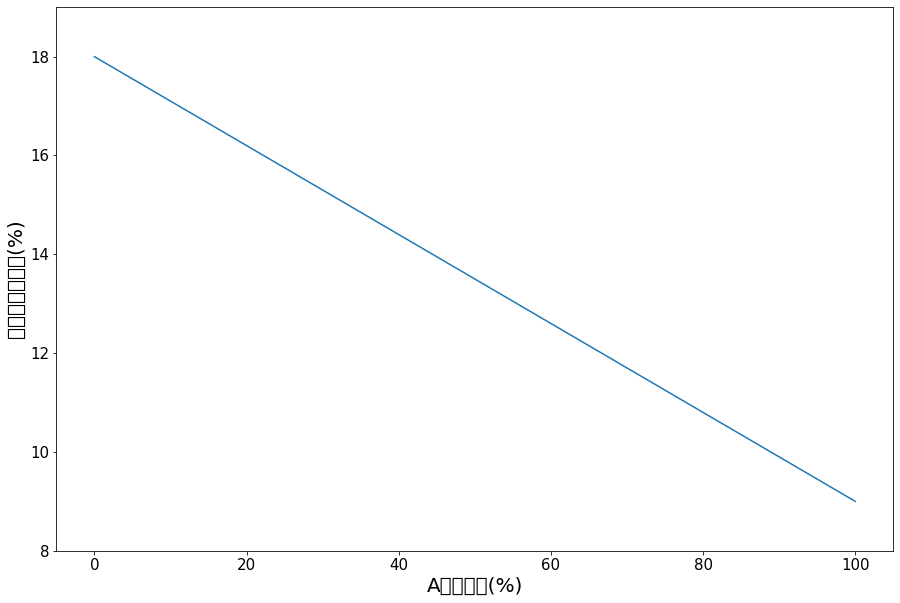

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# 預期報酬計算公式
def exp_return(x):
    return(9*x+18*(1-x))

# 計算不同組合下的預期報酬
rets=list(map(exp_return,[x/100 for x in range(101)]))

# 轉成 dataframe
rets_df = pd.DataFrame(index=list(range(0, 101)), data=rets, columns=['expected return'])

# 畫圖
plt.figure(figsize=(15,10))
plt.plot(rets_df)
plt.ylim([8,19])
plt.xlabel("A資產佔比(%)", fontsize=20)
plt.ylabel("投組預期報酬率(%)", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25237 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32068 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27161 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 28310 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 24046 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 25237 missing from current font.
  font.set_

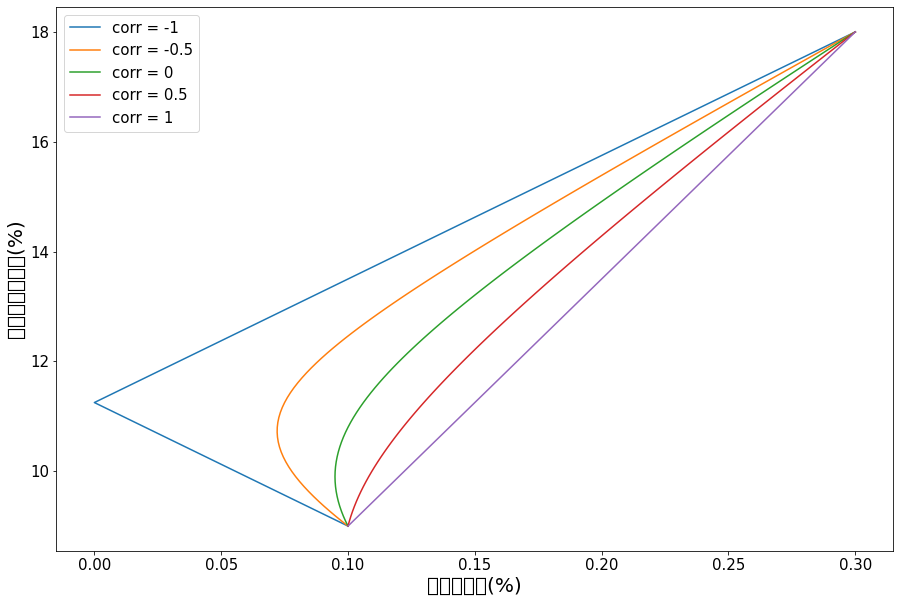

In [ ]:

import math
import pandas as pd
import numpy as np

#投資組合標準差與相關係數
def s(x, Sa, Sb, corr):
    return math.sqrt( (x**2) * Sa**2 + ((1-x)**2) * Sb**2 + 2 * x * (1-x) * corr * Sa * Sb )



# params
corr_set = [-1, -0.5, 0, 0.5, 1]

# standard deviation set
std_dev = []

# calculate standard deviations
for corr in corr_set:
    std_dev.append(s(0.6, 0.1, 0.3, corr))
df = pd.DataFrame({'corr': corr_set, 'std_dev': std_dev}, columns = ['corr','std_dev'])

# 投組標準差資料集合
std_dev_sets = []

# 計算標準差
for corr in corr_set:
    std_dev = []
    for x in range(0,101):
        std_dev.append(s(x/100, 0.1, 0.3, corr))
    std_dev_sets.append(std_dev)

# 繪圖
plt.figure(figsize=(15,10))
plt.plot(std_dev_sets[0],rets,label='corr = -1')
plt.plot(std_dev_sets[1],rets,label='corr = -0.5')
plt.plot(std_dev_sets[2],rets,label='corr = 0')
plt.plot(std_dev_sets[3],rets,label='corr = 0.5')
plt.plot(std_dev_sets[4],rets,label='corr = 1')
plt.xlabel('投組標準差(%)', fontsize=20)
plt.ylabel('投組預期報酬率(%)', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='upper left',prop={'size': 15})


# Day23 - 投資組合概念(三) 股債配比分析

In [ ]:
import os
import pandas_datareader as pdr
SPY = pdr.get_data_tiingo('SPY', api_key='4d109a21f529efe178e73aae6e710b8c24330e71')
TLT = pdr.get_data_tiingo('TLT', api_key='4d109a21f529efe178e73aae6e710b8c24330e71')
SPY.reset_index(inplace=True)
TLT.reset_index(inplace=True)

import pandas as pd
Close = pd.concat([SPY.adjClose, TLT.adjClose], axis = 1)
Close.index = SPY.date
Close.columns = ['SPY', 'TLT']
Close

,SPY,TLT
date,,
2016-01-20 00:00:00+00:00,168.483008,113.067642
2016-01-21 00:00:00+00:00,169.426847,112.300053
2016-01-22 00:00:00+00:00,172.902690,111.871631
2016-01-25 00:00:00+00:00,170.288998,112.478562
2016-01-26 00:00:00+00:00,172.612274,112.532115
...,...,...
2021-01-11 00:00:00+00:00,378.690000,151.070000
2021-01-12 00:00:00+00:00,378.770000,150.950000
2021-01-13 00:00:00+00:00,379.790000,152.650000


In [ ]:
import numpy as np
corr_matrix = Close.pct_change().apply(lambda x: np.log(1+x)).corr()
corr_matrix

,SPY,TLT
SPY,1.00000,-0.40749
TLT,-0.40749,1.00000


In [ ]:
expected_return = Close.resample('Y').last()[:-1].pct_change().mean()
expected_return

SPY    0.166845
TLT    0.099617
dtype: float64

In [ ]:
standard_dev = Close.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
standard_dev

SPY    0.187899
TLT    0.137413
dtype: float64

In [ ]:
return_dev_matrix = pd.concat([expected_return, standard_dev], axis = 1)
return_dev_matrix.columns = ['Exp Returns', 'Standard Dev.']
return_dev_matrix

,Exp Returns,Standard Dev.
SPY,0.166845,0.187899
TLT,0.099617,0.137413


In [ ]:
# 投組報酬率
port_ret = []

# 投組標準差
port_dev = []

# 投組比例
port_weights = []

# 投組商品數
assets_nums = 2

# 不同投組的數量，點越多代表組合越多種，圖畫出來就越密
port_nums = 2000

# 計算共變異數
cov_matrix = Close.pct_change().apply(lambda x: np.log(1+x)).cov()

# random兩千個不同比例的投組，算出報酬率跟標準差
for port in range(2000):
    # random比例
    weights = np.random.random(assets_nums)
    weights = weights/np.sum(weights)
    port_weights.append(weights)
    
    # 計算平均報酬
    returns = np.dot(weights, expected_return)
    port_ret.append(returns)
    
    # 計算標準差
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var)
    ann_sd = sd*np.sqrt(250)
    port_dev.append(ann_sd)

# 將資料整合成一個dataframe
data = {'Returns': port_ret, 'Standard Dev.': port_dev}

# 標註每個row使用的投組比例是多少
for counter, symbol in enumerate(Close.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in port_weights]
    
# 整理資料成表格
portfolios = pd.DataFrame(data)
portfolios.head()

,Returns,Standard Dev.,SPY weight,TLT weight
0,0.124137,0.086264,0.364726,0.635274
1,0.140905,0.105554,0.614154,0.385846
2,0.152365,0.138038,0.784605,0.215395
3,0.155098,0.146925,0.825255,0.174745
4,0.154008,0.143343,0.809044,0.190956


(array([0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18]),
 <a list of 10 Text major ticklabel objects>)

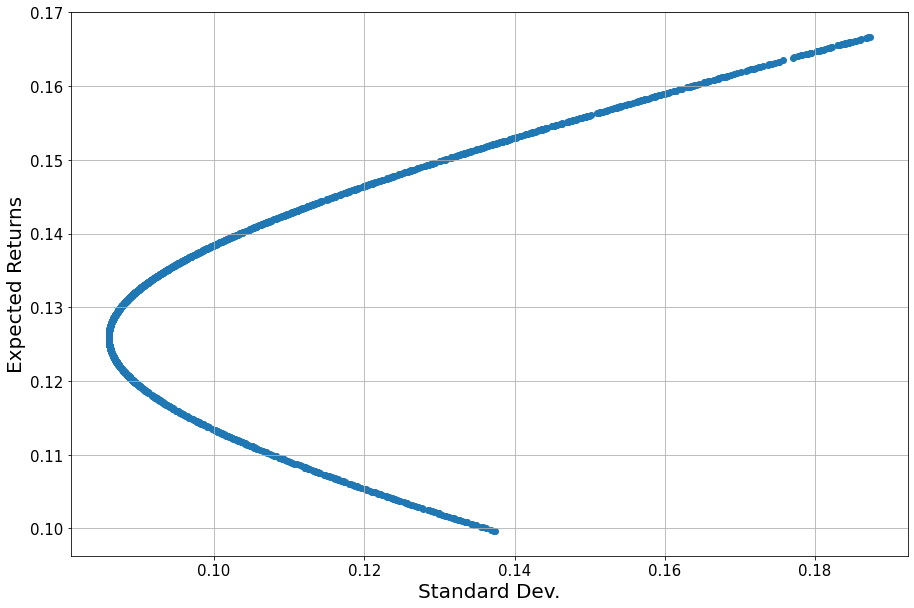

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.scatter(x = portfolios['Standard Dev.'], y = portfolios['Returns'])
plt.grid()
plt.xlabel("Standard Dev.", fontsize=20)
plt.ylabel("Expected Returns", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Day24 - 投資組合概念(四) 效率前緣

In [ ]:
# 爬蟲
import os
import pandas_datareader as pdr
SPY = pdr.get_data_tiingo('SPY', api_key='4d109a21f529efe178e73aae6e710b8c24330e71')
TLT = pdr.get_data_tiingo('TLT', api_key='4d109a21f529efe178e73aae6e710b8c24330e71')
GLD = pdr.get_data_tiingo('GLD', api_key='4d109a21f529efe178e73aae6e710b8c24330e71')
SPY.reset_index(inplace=True)
TLT.reset_index(inplace=True)
GLD.reset_index(inplace=True)

# 整理
import pandas as pd
Close = pd.concat([SPY.adjClose, TLT.adjClose, GLD.adjClose], axis = 1)
Close.index = SPY.date
Close.columns = ['SPY', 'TLT', 'GLD']

# 共變異數矩陣
import numpy as np
cov_matrix = Close.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

,SPY,TLT,GLD
SPY,0.000141,-0.000042,-0.000001
TLT,-0.000042,0.000076,0.000026
GLD,-0.000001,0.000026,0.000078


In [ ]:
# 平均報酬率
expected_return = Close.resample('Y').last()[:-1].pct_change().mean()
expected_return

SPY    0.166845
TLT    0.099617
GLD    0.133846
dtype: float64

In [ ]:
# 標準差
standard_dev = Close.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
standard_dev

SPY    0.187899
TLT    0.137413
GLD    0.139547
dtype: float64

In [ ]:
# 整理成表格
return_dev_matrix = pd.concat([expected_return, standard_dev], axis = 1)
return_dev_matrix.columns = ['Exp Returns', 'Standard Dev.']
return_dev_matrix

,Exp Returns,Standard Dev.
SPY,0.166845,0.187899
TLT,0.099617,0.137413
GLD,0.133846,0.139547


In [ ]:
port_ret = []
port_dev = []
port_weights = []
assets_nums = 3
port_nums = 2000

for port in range(2000):
    weights = np.random.random(assets_nums)
    weights = weights/np.sum(weights)
    port_weights.append(weights)
    returns = np.dot(weights, expected_return)
    port_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var)
    ann_sd = sd*np.sqrt(250)
    port_dev.append(ann_sd)
    
data = {'Returns': port_ret, 'Standard Dev.': port_dev}

for counter, symbol in enumerate(Close.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in port_weights]
    
portfolios = pd.DataFrame(data)
portfolios.head()

,Returns,Standard Dev.,SPY weight,TLT weight,GLD weight
0,0.132145,0.083916,0.410213,0.445158,0.144629
1,0.124917,0.086995,0.209248,0.462587,0.328166
2,0.127727,0.081943,0.327593,0.494584,0.177823
3,0.126060,0.105249,0.084164,0.308603,0.607232
4,0.146777,0.106695,0.510184,0.114083,0.375734


(array([0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17]),
 <a list of 9 Text major ticklabel objects>)

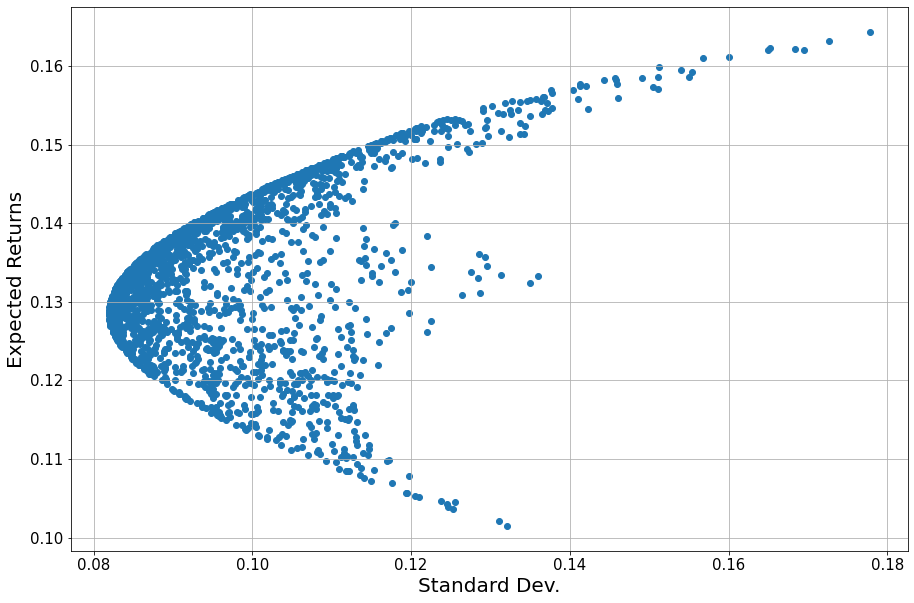

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.scatter(x = portfolios['Standard Dev.'], y = portfolios['Returns'])
plt.grid()
plt.xlabel("Standard Dev.", fontsize=20)
plt.ylabel("Expected Returns", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [ ]:
# 取效率前緣
std = []
ret = [portfolios[portfolios['Standard Dev.'] == portfolios['Standard Dev.'].min()]['Returns'].values[0]]
eff_front_set = pd.DataFrame(columns=['Returns', 'Standard Dev.', 'SPY weight', 'TLT weight', 'GLD weight'])
for i in range(800,1800,1):
    df = portfolios[(portfolios['Standard Dev.'] >= i/10000) & (portfolios['Standard Dev.'] <= (i+15)/10000)]
    try:
        # 上側
        max_ret = df[df['Returns'] == df['Returns'].max()]['Returns'].values[0]
        if max_ret >= max(ret):
            std.append(df[df['Returns'] == df['Returns'].max()]['Standard Dev.'].values[0])
            ret.append(df[df['Returns'] == df['Returns'].max()]['Returns'].values[0])
            eff_front_set = eff_front_set.append(df[df['Returns'] == df['Returns'].max()], ignore_index = True)
    except:
        pass

ret.pop(0)
eff_front_std = pd.Series(std)
eff_front_ret = pd.Series(ret)

(array([0.09, 0.1 , 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17]),
 <a list of 9 Text major ticklabel objects>)

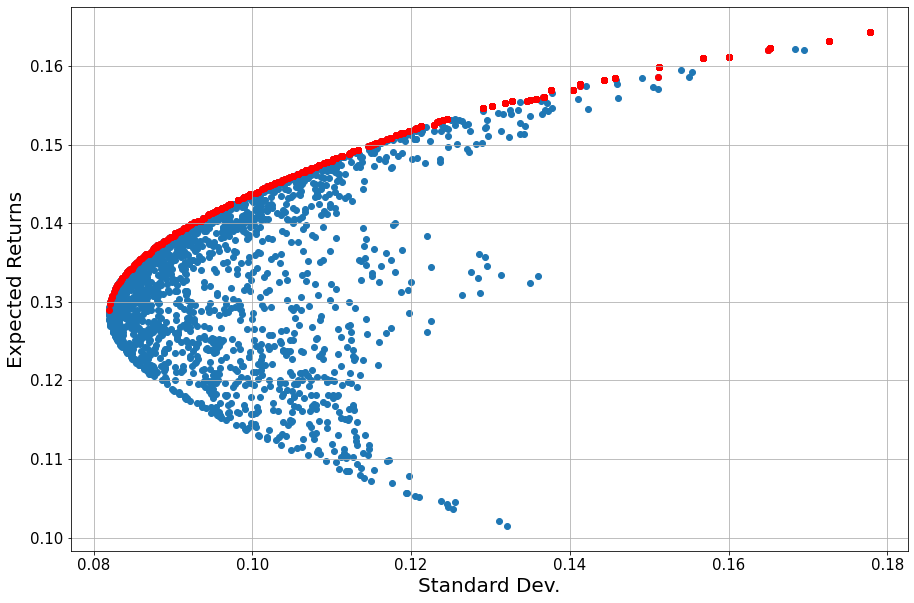

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(x = portfolios['Standard Dev.'], y = portfolios['Returns'])
# 效率前緣點，用紅色標註
plt.scatter(x = eff_front_std, y = eff_front_ret, c = 'r')
plt.grid()
plt.xlabel("Standard Dev.", fontsize=20)
plt.ylabel("Expected Returns", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [ ]:
eff_front_set

,Returns,Standard Dev.,SPY weight,TLT weight,GLD weight
0,0.128909,0.081885,0.337263,0.469365,0.193372
1,0.129692,0.081989,0.339490,0.448649,0.211862
2,0.129975,0.082067,0.339028,0.439943,0.221029
3,0.130365,0.082200,0.339793,0.429264,0.230943
4,0.130666,0.082288,0.343726,0.424287,0.231986
...,...,...,...,...,...
675,0.164381,0.177757,0.954087,0.027724,0.018189
676,0.164381,0.177757,0.954087,0.027724,0.018189
677,0.164381,0.177757,0.954087,0.027724,0.018189
678,0.164381,0.177757,0.954087,0.027724,0.018189


# Day25 - 投資組合概念(五) Sharpe ratio

(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16]),
 <a list of 9 Text major ticklabel objects>)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32654 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22283 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20844 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20661 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 32654 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 22283 missing from current font.
  font.set_te

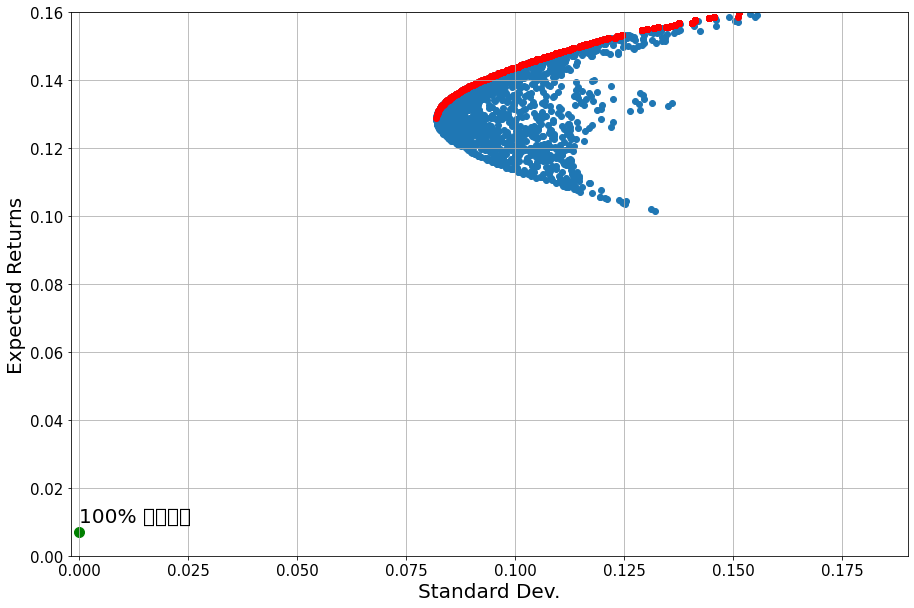

In [ ]:
# 跟前一篇寫的程式碼大致相同，只修改繪圖部分：
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.scatter(x = portfolios['Standard Dev.'], y = portfolios['Returns'])
# 效率前緣點，用紅色標註
plt.scatter(x = eff_front_std, y = eff_front_ret, c = 'r')
# 無風險資產
plt.scatter(x = 0, y = 0.007, c = 'g', s = 100)
plt.annotate("100% 美國公債", (0,0.007), textcoords="offset points", xytext=(0,10), ha='left', fontsize=20)
# 繪圖設定
plt.grid()
plt.xlabel("Standard Dev.", fontsize=20)
plt.ylabel("Expected Returns", fontsize=20)
plt.xlim(-0.002,0.19)
plt.ylim(0,0.16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [ ]:
# 找夏普比率最大的投組
max_sharpe = 0
max_sharpe_returns = 0
max_sharpe_std = 0
for i in range(len(eff_front_set)):
    sharpe = ( eff_front_set.iloc[i,:]['Returns'] - 0.007 ) / eff_front_set.iloc[i,:]['Standard Dev.']
    if sharpe > max_sharpe:
        max_sharpe = sharpe
        max_sharpe_std = eff_front_set.iloc[i,:]['Standard Dev.']
        max_sharpe_returns = eff_front_set.iloc[i,:]['Returns']
        max_sharpe_set = (eff_front_set.iloc[i,:]['SPY weight'], eff_front_set.iloc[i,:]['TLT weight'], eff_front_set.iloc[i,:]['GLD weight'])
print("夏普比率最大點的報酬率與標準差 ", "(Returns, Standard Dev.) =", (max_sharpe_returns, max_sharpe_std))
print("夏普比率最大點的投組", "(SPY weight, TLT weight, GLD weight) =", max_sharpe_set)

夏普比率最大點的報酬率與標準差  (Returns, Standard Dev.) = (0.13227416239775638, 0.08304989009198152)
夏普比率最大點的投組 (SPY weight, TLT weight, GLD weight) = (0.37270952183058215, 0.4052364701332694, 0.22205400803614833)


(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16]),
 <a list of 9 Text major ticklabel objects>)

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32654 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22283 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20844 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20661 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 32654 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 22283 missing from current font.
  font.set_te

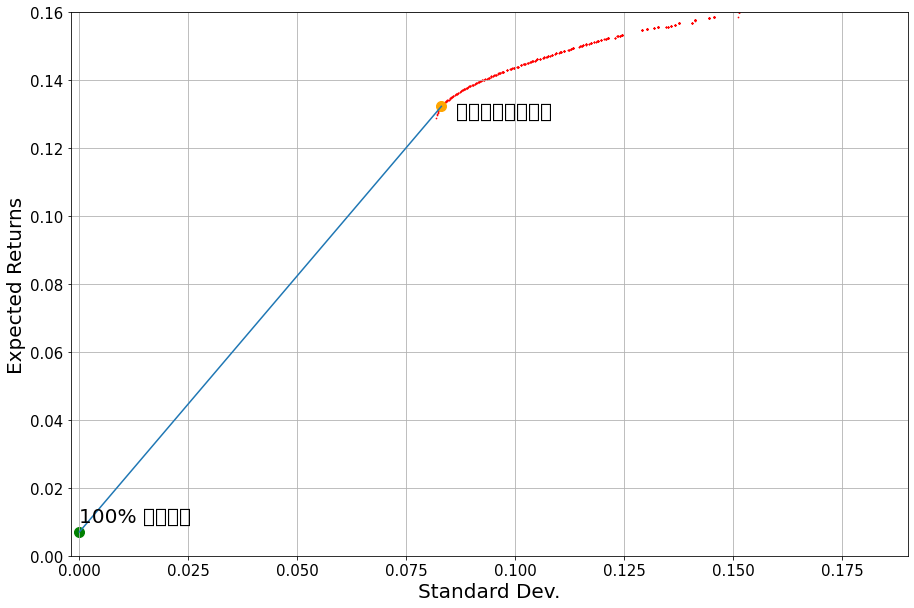

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
# 效率前緣點，用紅色標註
plt.scatter(x = eff_front_std, y = eff_front_ret, c = 'r', s = 0.5)
# 無風險資產
plt.scatter(x = 0, y = 0.007, c = 'g', s = 100)
plt.annotate("100% 美國公債", (0,0.007), textcoords="offset points", xytext=(0,10), ha='left', fontsize=20)
# max sharpe set
plt.scatter(x = max_sharpe_std, y = max_sharpe_returns, c = 'orange', s = 100)
plt.annotate("最大夏普比率投組", (max_sharpe_std, max_sharpe_returns), textcoords="offset points", xytext=(15,-10), ha='left', fontsize=20)
# 切線
plt.plot([0,max_sharpe_std],[0.007, max_sharpe_returns])
# 繪圖設定
plt.grid()
plt.xlabel("Standard Dev.", fontsize=20)
plt.ylabel("Expected Returns", fontsize=20)
plt.xlim(-0.002,0.19)
plt.ylim(0,0.16)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Day26 - 投資組合概念(六) CAPM的由來

intro

# Day27 - 投資組合概念(七) Jensen alpha

intro

# Day28 - 投資組合概念(八) CAPM實際應用

In [ ]:
import os
import pandas_datareader as pdr
SPY = pdr.get_data_tiingo('SPY', api_key='4d109a21f529efe178e73aae6e710b8c24330e71')
AAPL = pdr.get_data_tiingo('AAPL', api_key='4d109a21f529efe178e73aae6e710b8c24330e71')

# SPY 2019 日報酬率
SPY = SPY.reset_index(level=[0,1])
SPY.index = SPY['date']
SPY_adj = SPY.iloc[:,7:11]
SPY_adj.columns = ['Close','High','Low','Open']
SPY_Close_adj = SPY_adj.Close
ret1 = SPY_Close_adj.shift(-2) / SPY_Close_adj.shift(-1)
spy_daily_ret = ret1 - 1
spy_daily_ret_2019 = spy_daily_ret['2019']

# AAPL 2019 日報酬率
AAPL = AAPL.reset_index(level=[0,1])
AAPL.index = AAPL['date']
AAPL_adj = AAPL.iloc[:,7:11]
AAPL_adj.columns = ['Close','High','Low','Open']
AAPL_Close_adj = AAPL_adj.Close
ret1 = AAPL_Close_adj.shift(-2) / AAPL_Close_adj.shift(-1)
aapl_daily_ret = ret1 - 1
aapl_daily_ret_2019 = aapl_daily_ret['2019']

# 整合成一個dataframe
import pandas as pd
ret_data = pd.concat([aapl_daily_ret_2019,spy_daily_ret_2019], axis = 1)
ret_data.columns = ['AAPL', 'SPY']
ret_data

,AAPL,SPY
date,,
2019-01-02 00:00:00+00:00,0.042689,0.033496
2019-01-03 00:00:00+00:00,-0.002226,0.007885
2019-01-04 00:00:00+00:00,0.019063,0.009395
2019-01-07 00:00:00+00:00,0.016982,0.004673
2019-01-08 00:00:00+00:00,0.003196,0.003528
...,...,...
2019-12-24 00:00:00+00:00,-0.000379,-0.000248
2019-12-26 00:00:00+00:00,0.005935,-0.005513
2019-12-27 00:00:00+00:00,0.007307,0.002429


In [ ]:
# risk free return
rf_ret = 1.0078 ** ( 1 / 252 ) - 1

Ex_ret = ret_data - rf_ret
Ex_ret

,AAPL,SPY
date,,
2019-01-02 00:00:00+00:00,0.042659,0.033465
2019-01-03 00:00:00+00:00,-0.002257,0.007854
2019-01-04 00:00:00+00:00,0.019032,0.009365
2019-01-07 00:00:00+00:00,0.016951,0.004643
2019-01-08 00:00:00+00:00,0.003165,0.003497
...,...,...
2019-12-24 00:00:00+00:00,-0.000410,-0.000279
2019-12-26 00:00:00+00:00,0.005904,-0.005544
2019-12-27 00:00:00+00:00,0.007276,0.002398


Text(0.5, 1.0, 'AAPL return and SPY return')

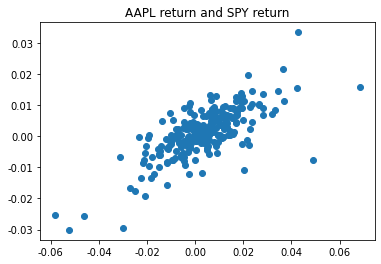

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus']=False

plt.scatter(Ex_ret.values[:,0],Ex_ret.values[:,1])
plt.title('AAPL return and SPY return')

In [ ]:
import statsmodels.api as sm

model=sm.OLS(Ex_ret.AAPL[1:],sm.add_constant(Ex_ret.SPY[1:]))
result=model.fit()
result.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   AAPL   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.531
Method:                 Least Squares   F-statistic:                     284.3
Date:                Mon, 18 Jan 2021   Prob (F-statistic):           4.51e-43
Time:                        07:17:16   Log-Likelihood:                 793.46
No. Observations:                 251   AIC:                            -1583.
Df Residuals:                     249   BIC:                            -1576.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      2.110      0.036    9.25e-05       0.003
SPY            1.4640      0.087     16.862      0.000       1.293       1.635
==============================================================================
Omnibus:                       72.254   Durbin-Watson:                   2.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              315.233
Skew:                           1.094   Prob(JB):                     3.53e-69
Kurtosis:                       8.035   Cond. No.                         134.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""